In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFpr, chi2, SelectFdr,f_classif, SequentialFeatureSelector, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


In [2]:
df=pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [3]:
df.drop('id',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                 

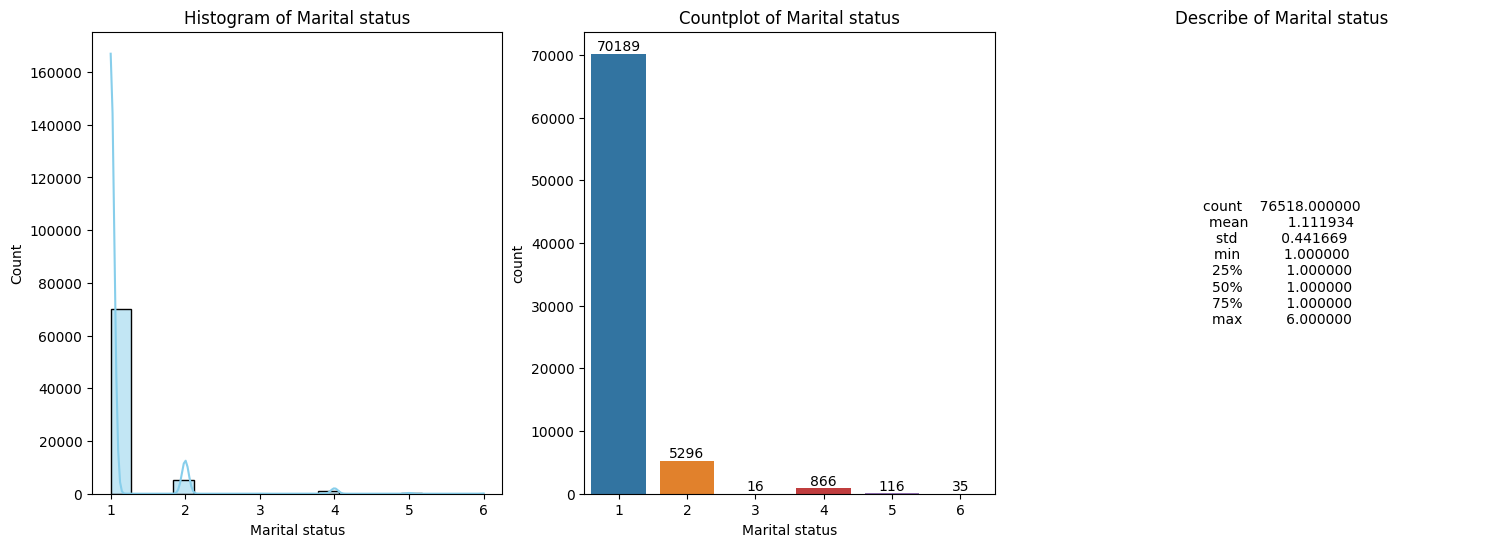

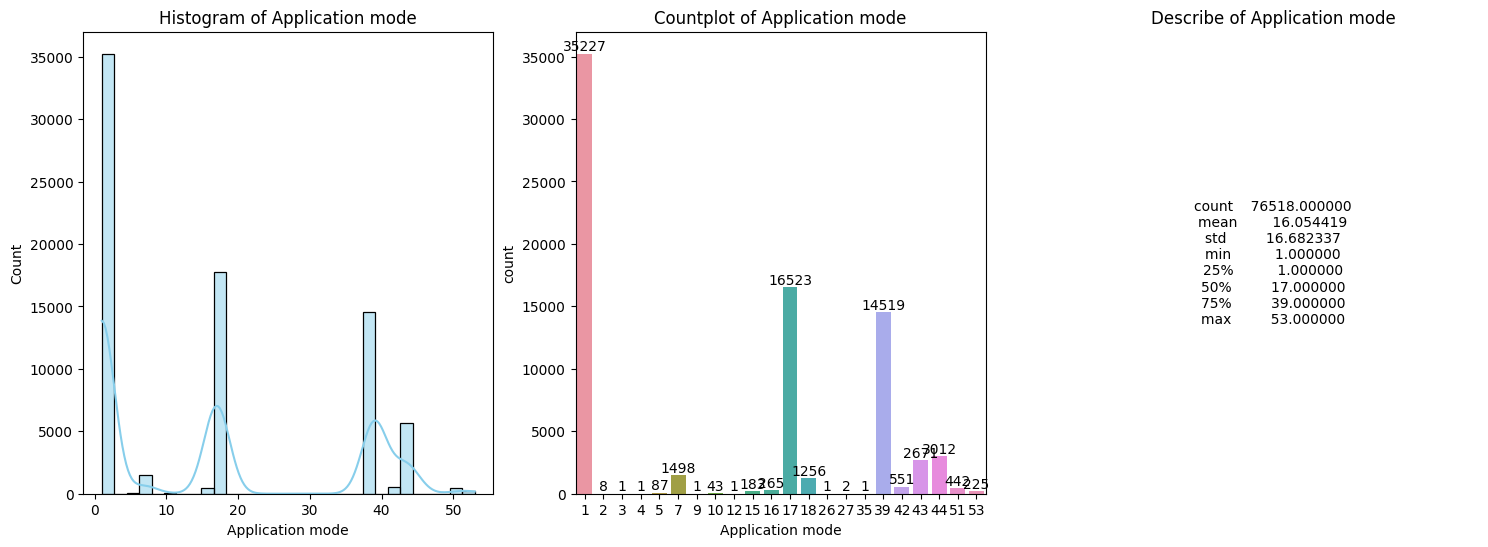

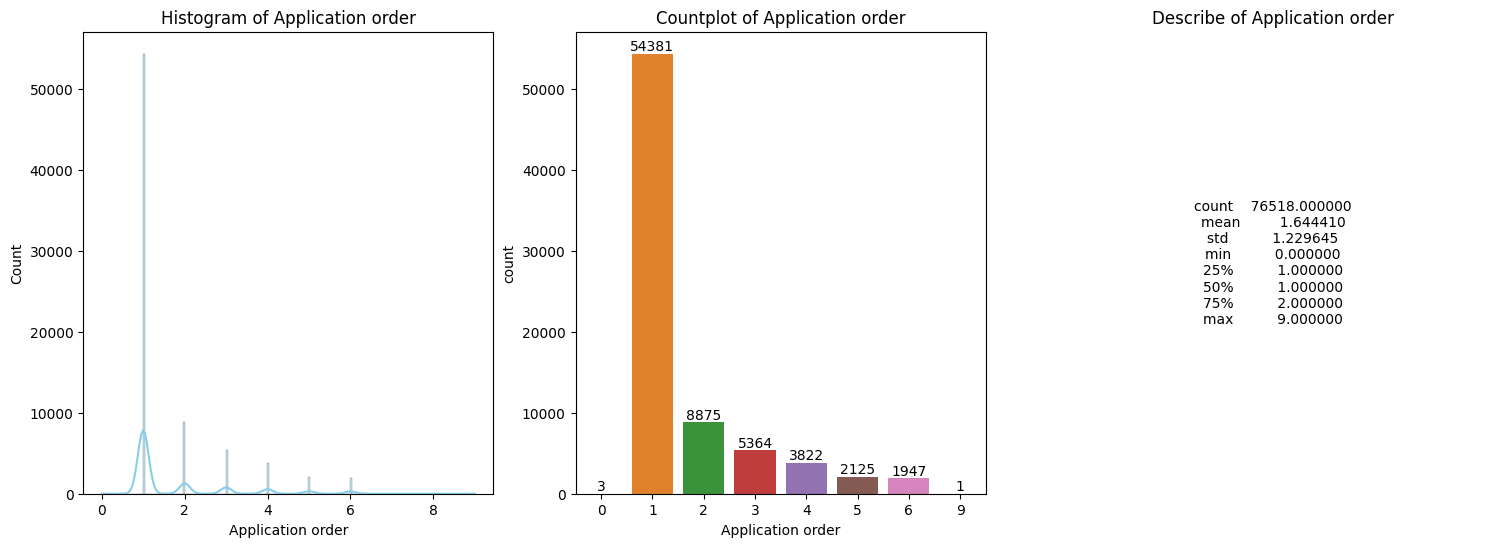

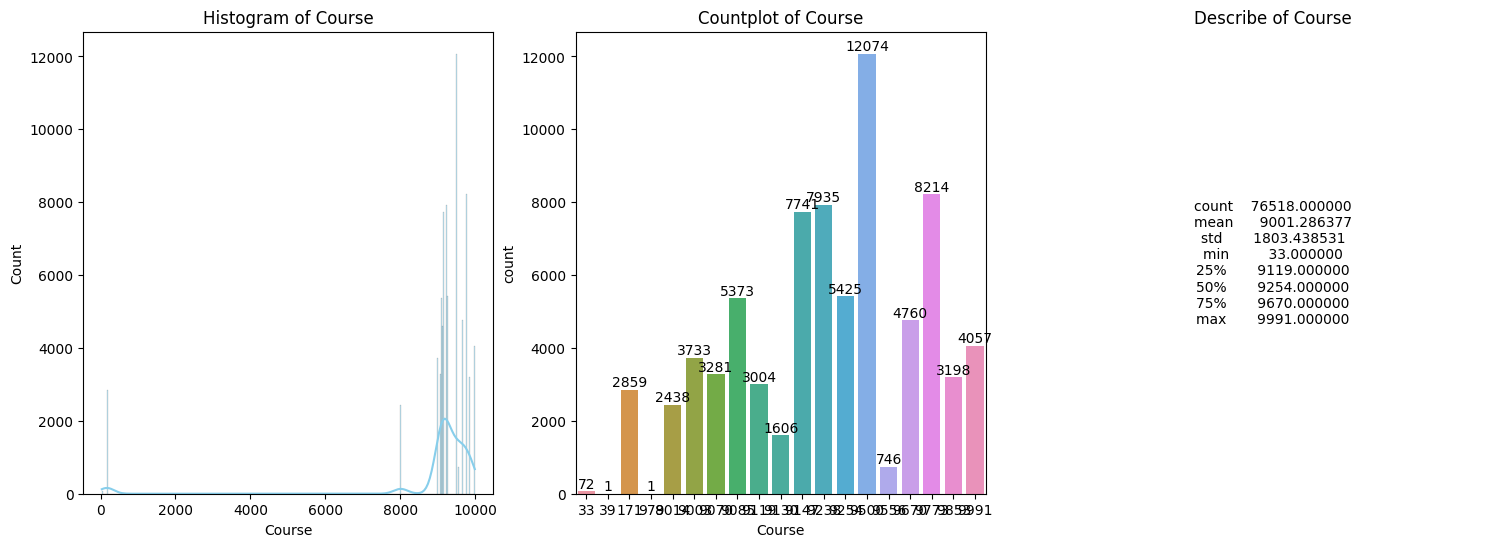

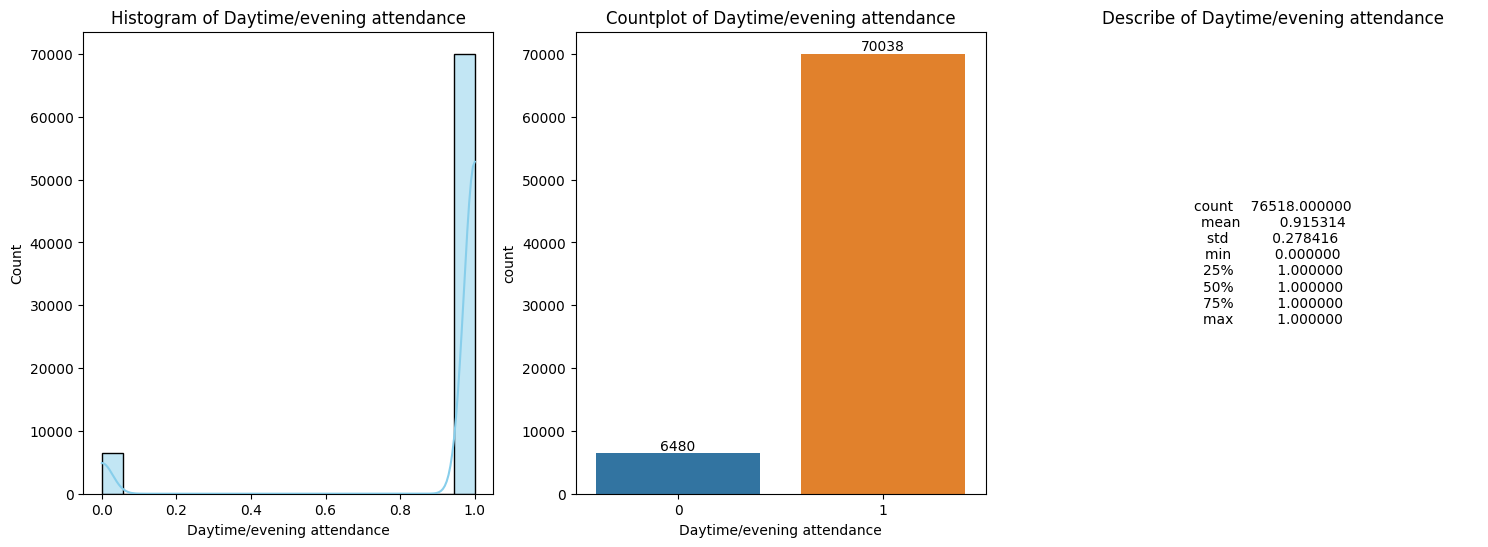

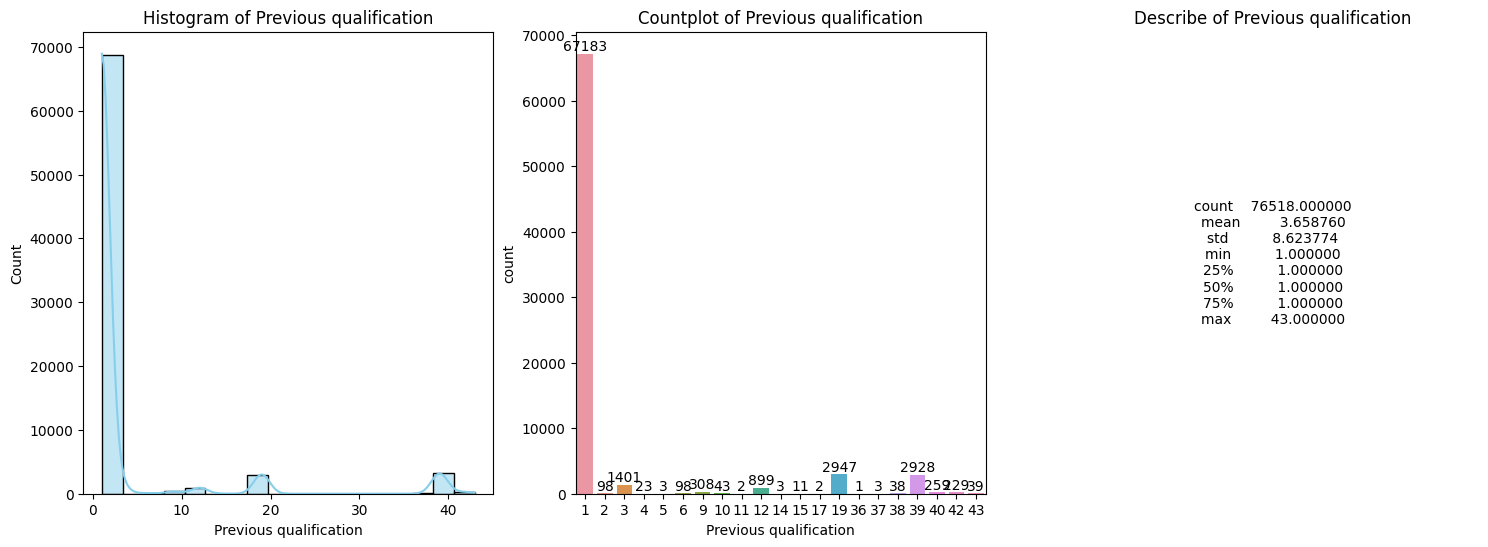

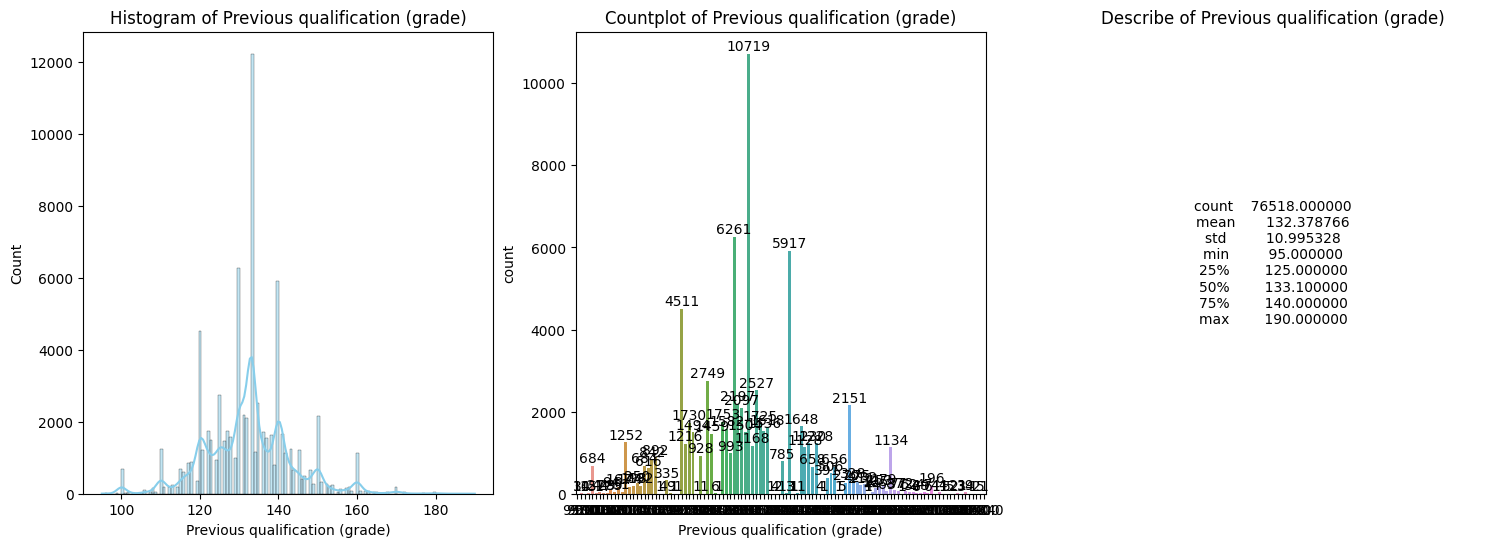

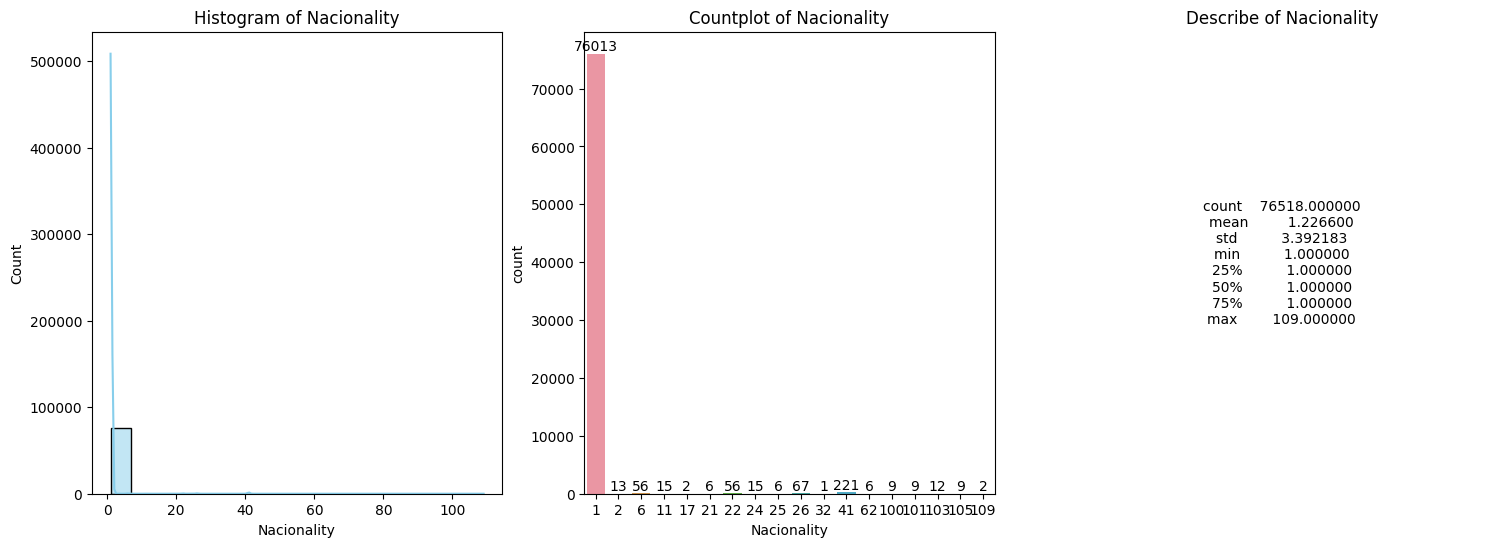

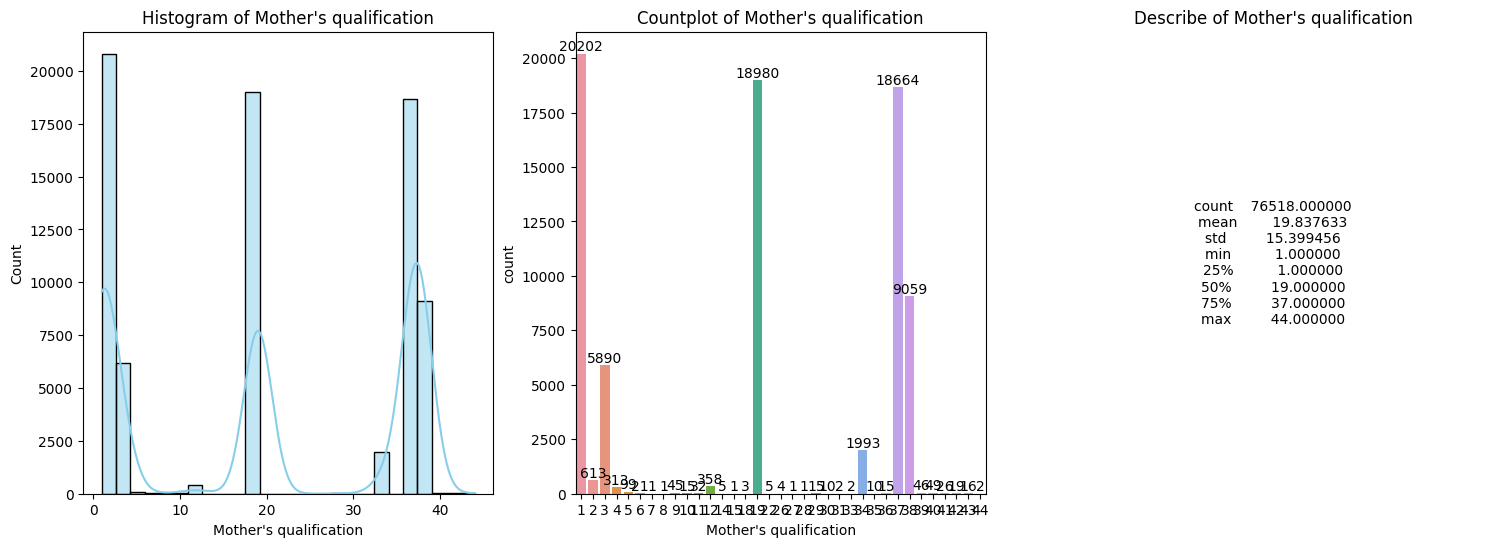

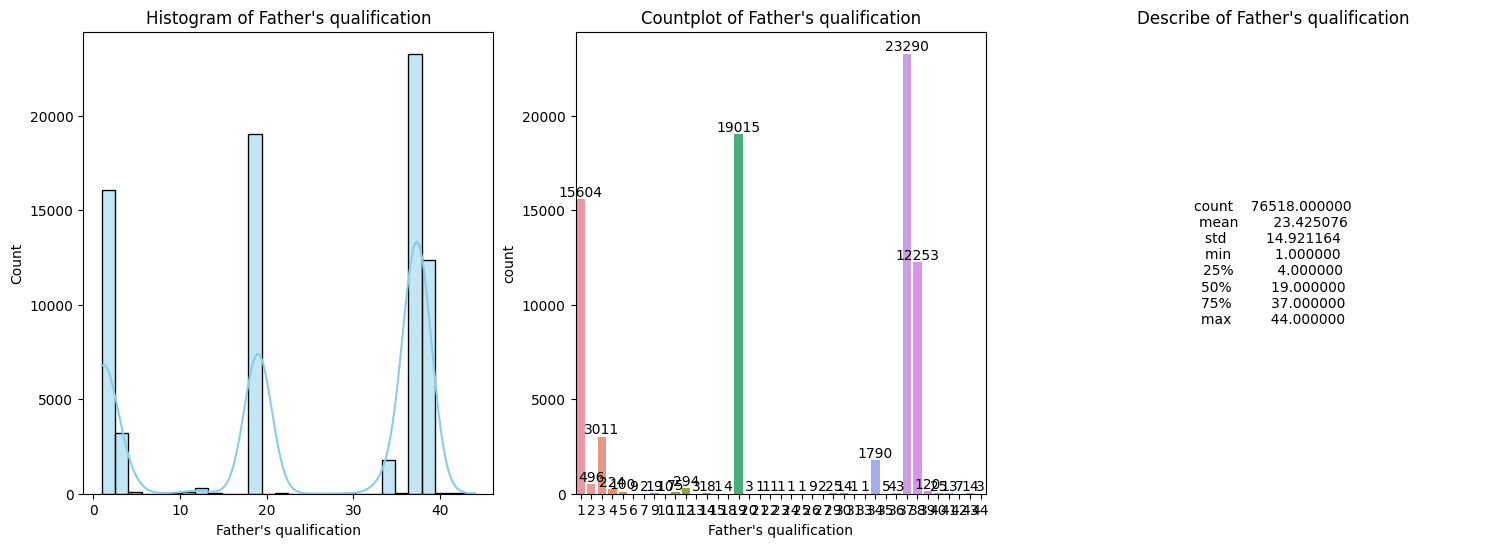

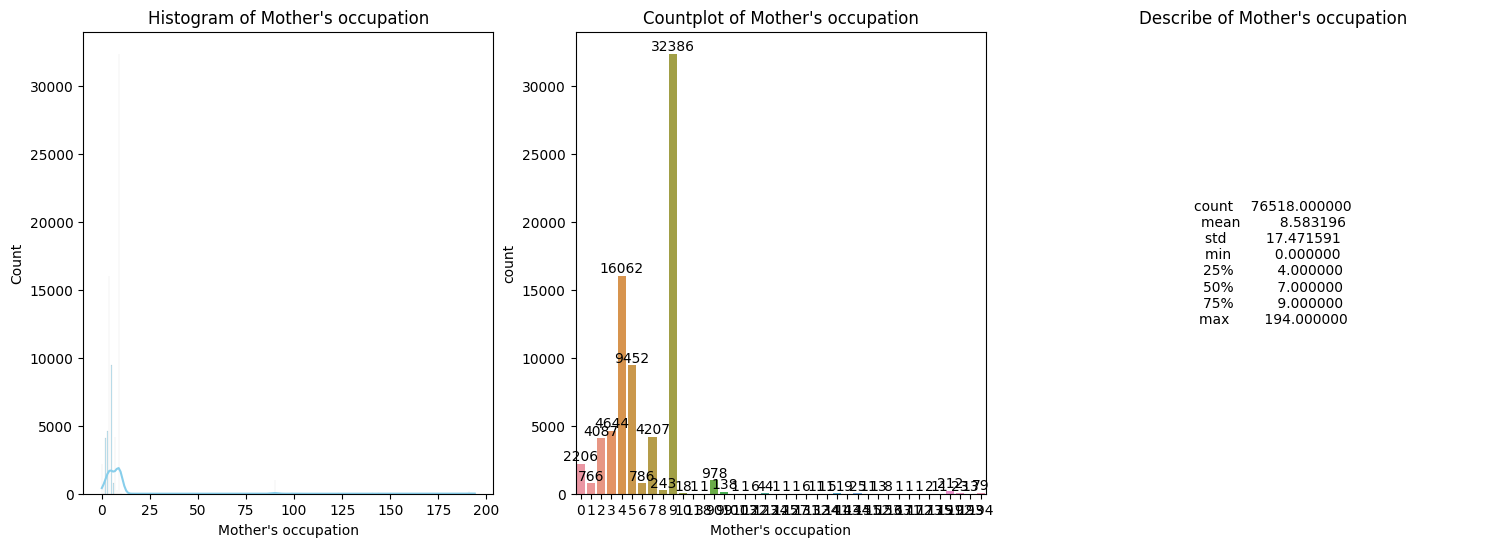

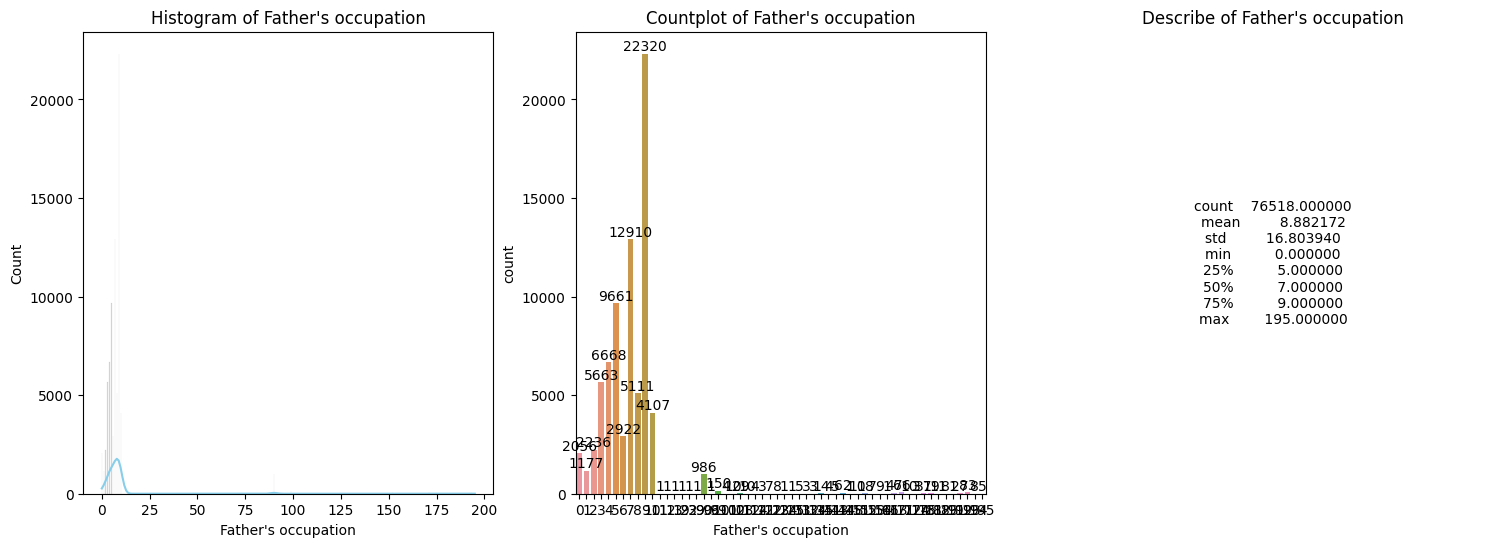

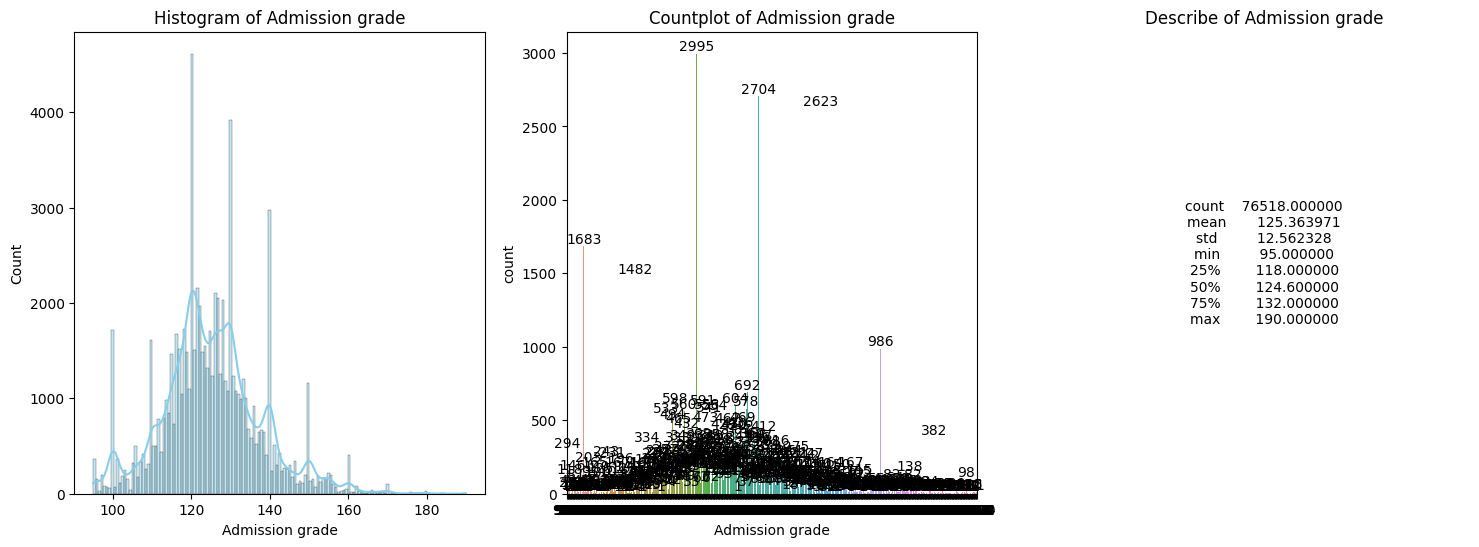

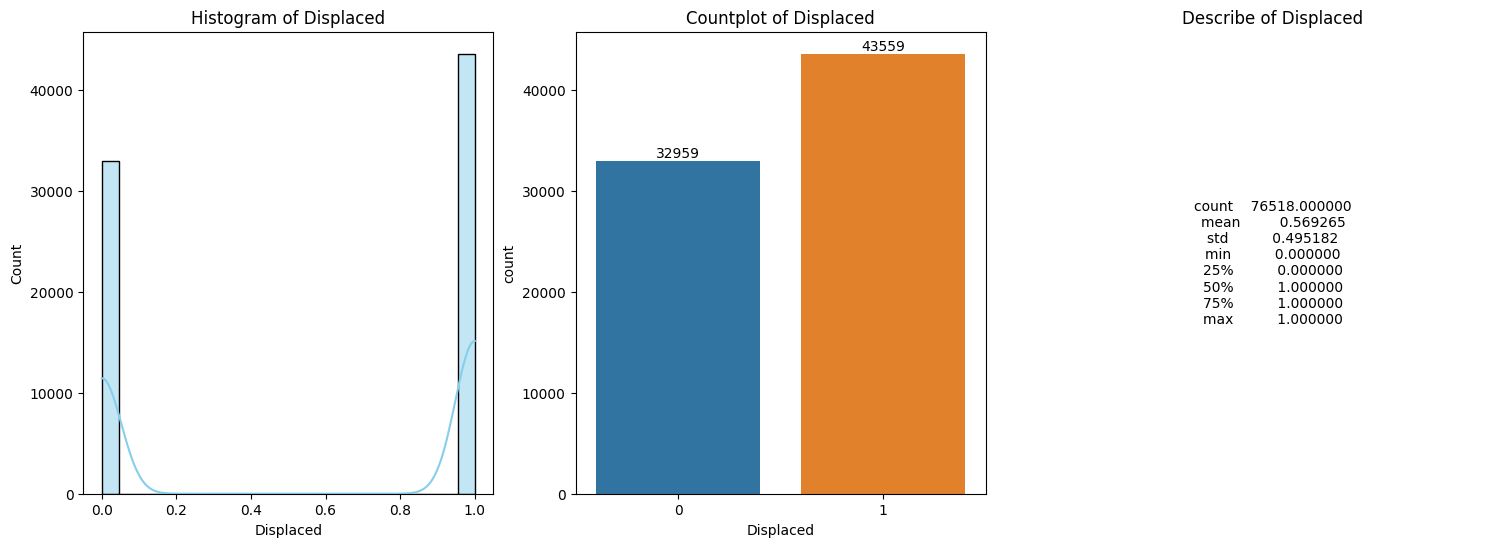

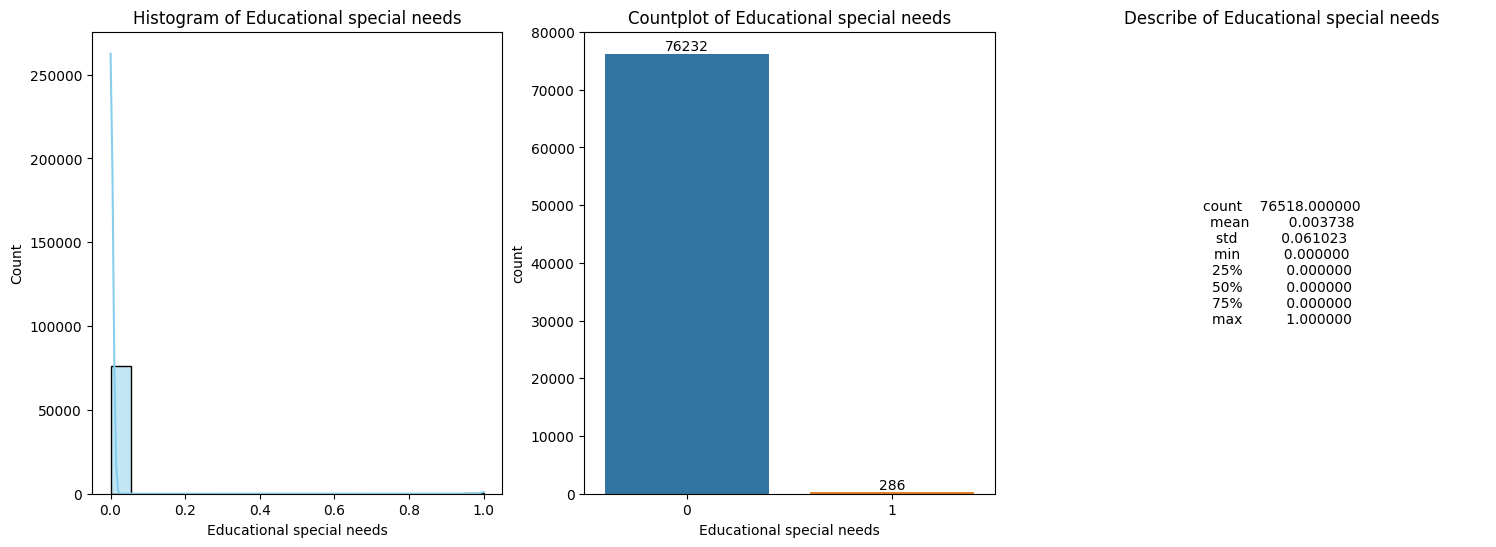

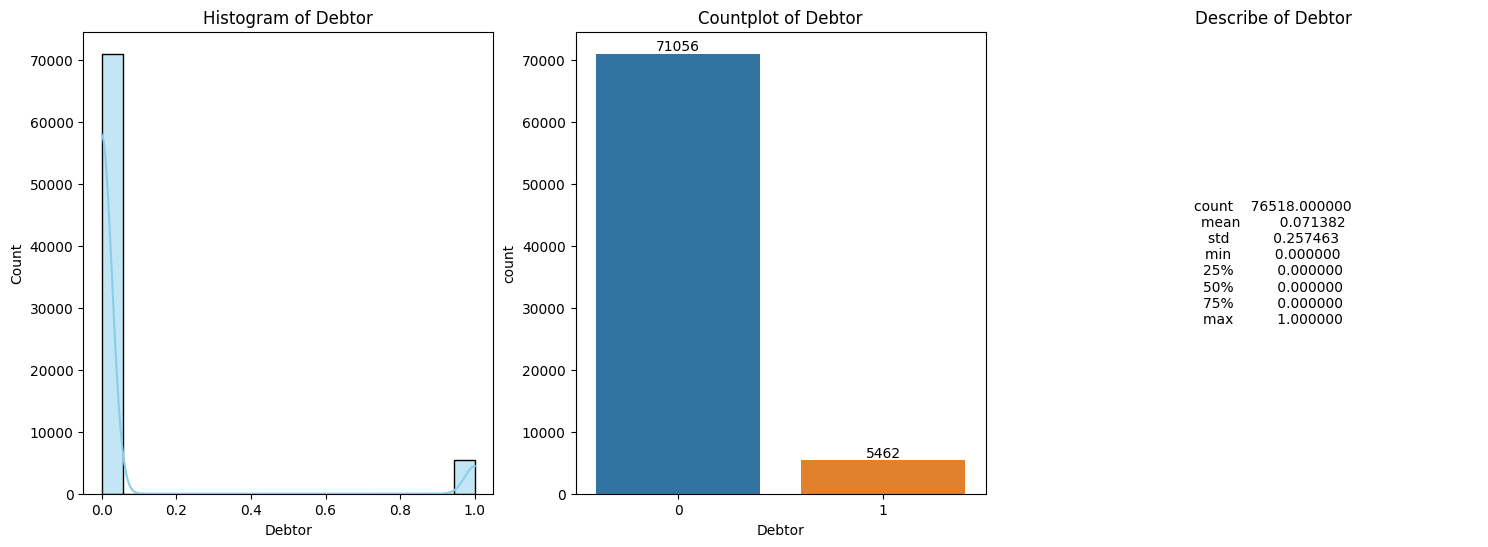

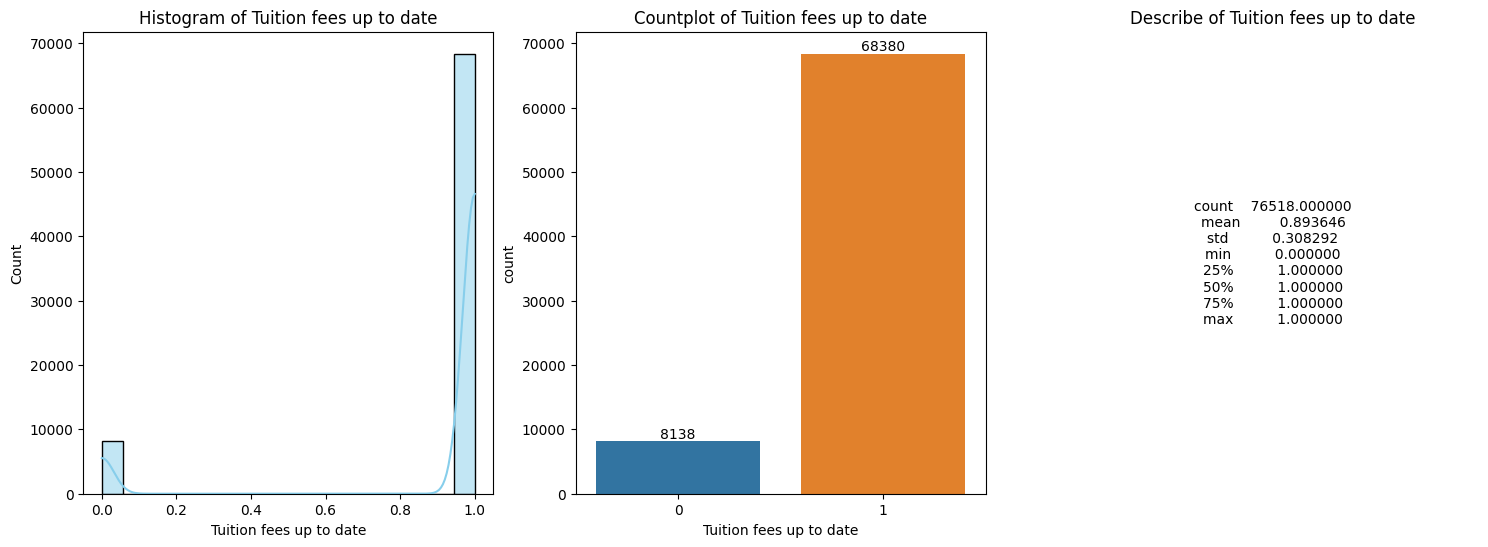

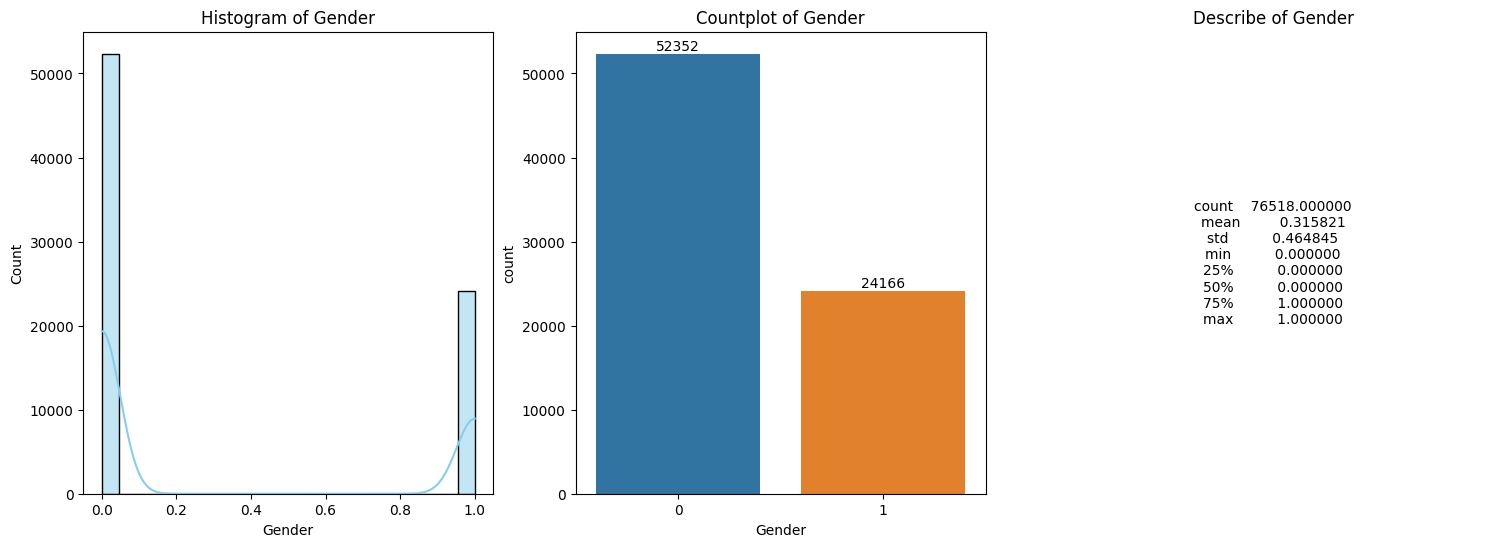

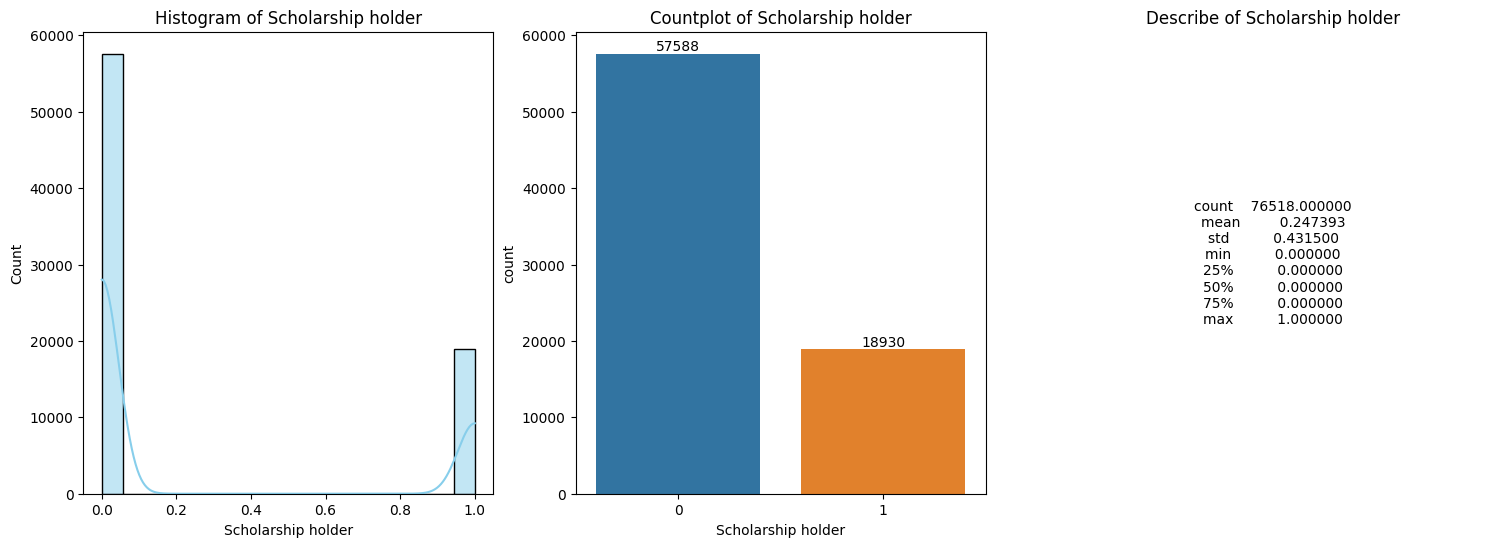

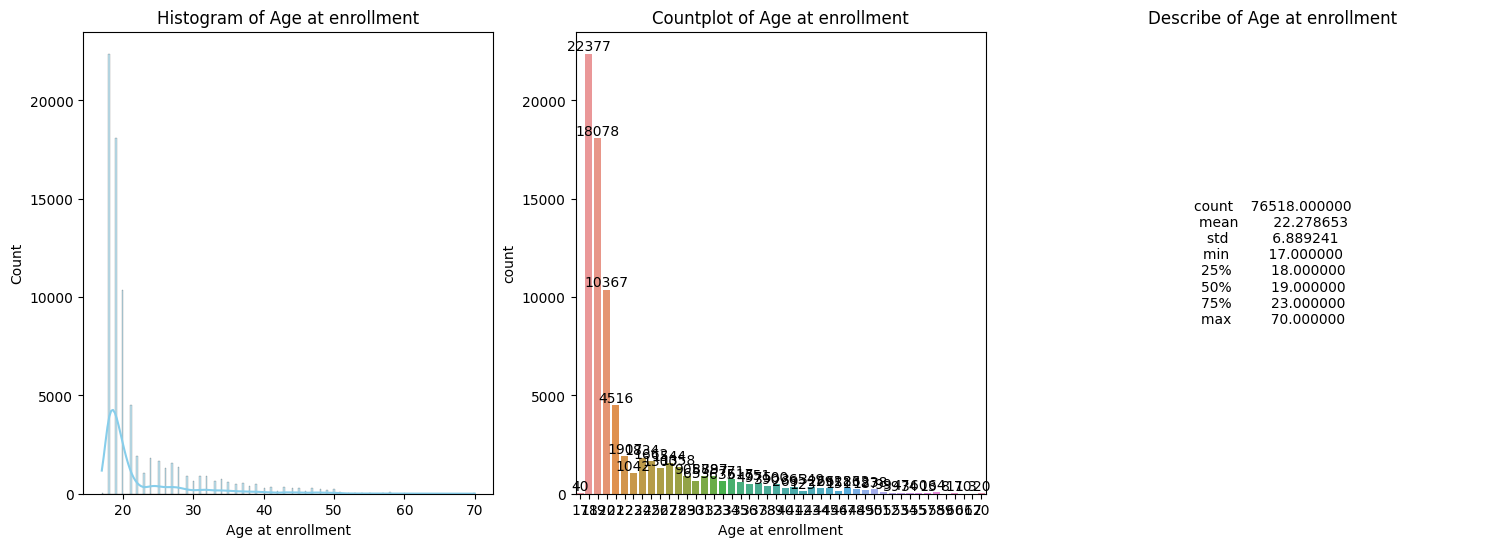

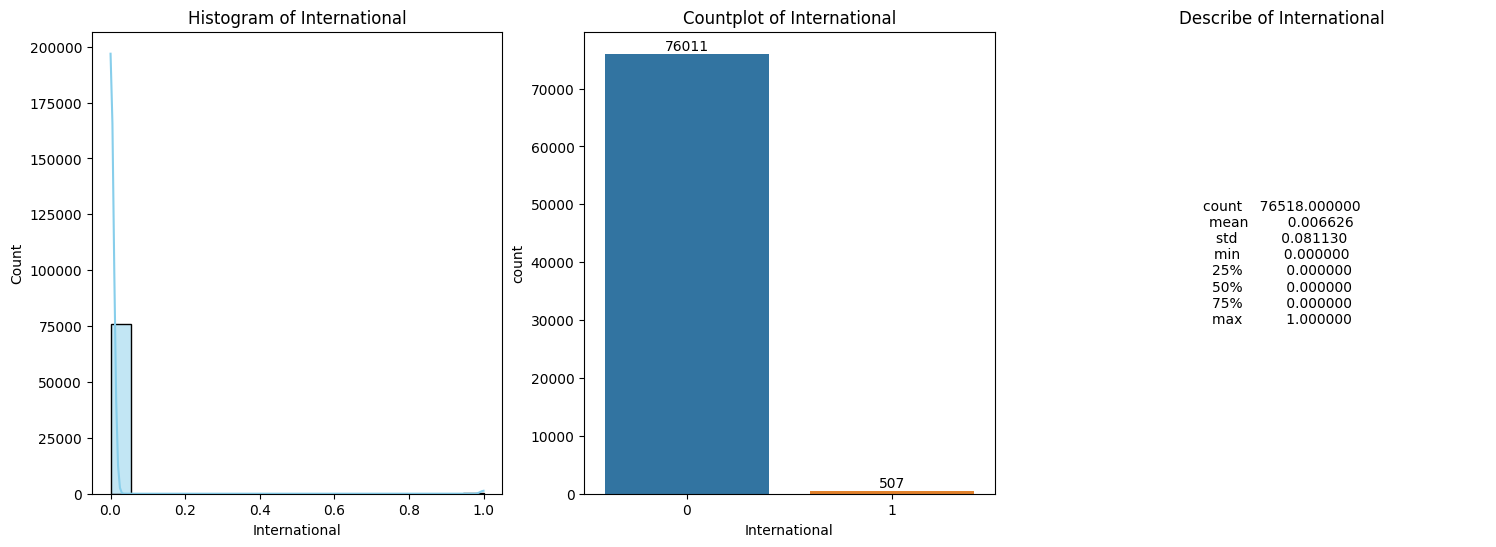

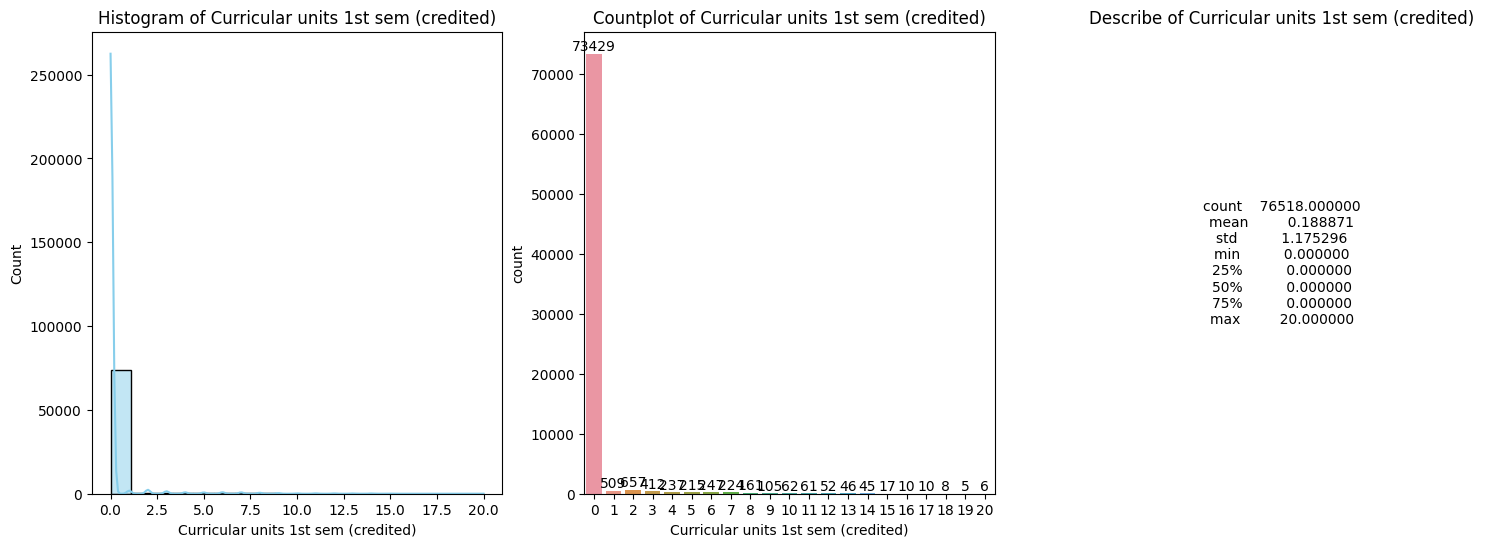

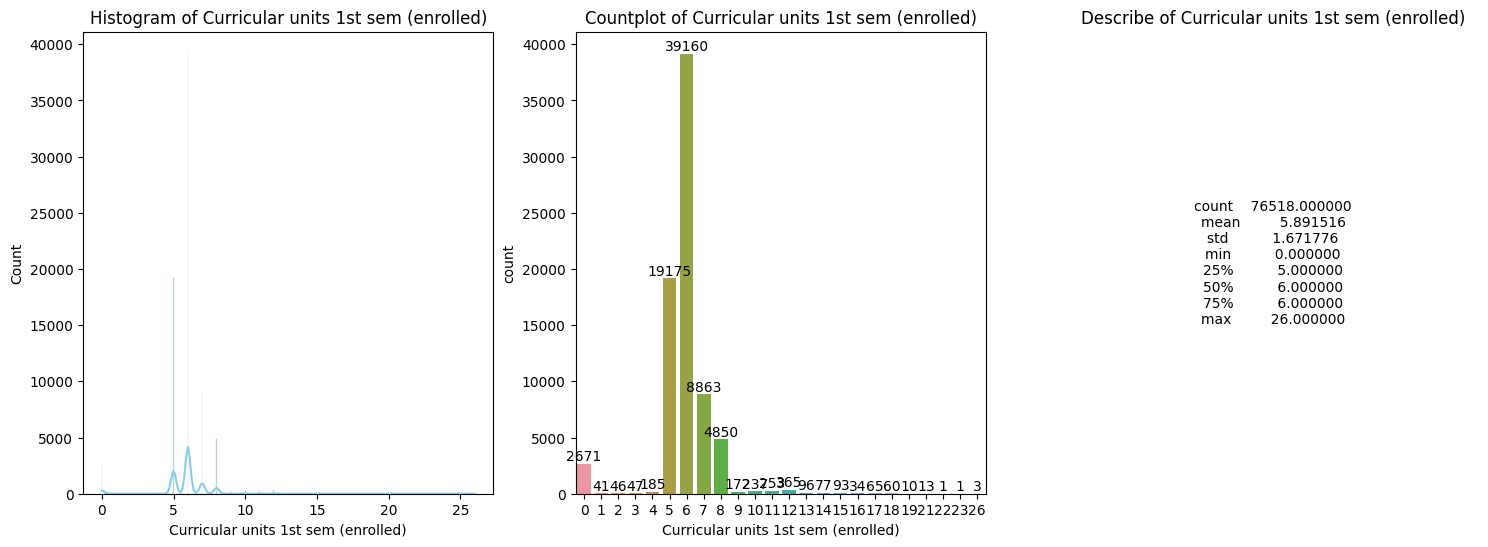

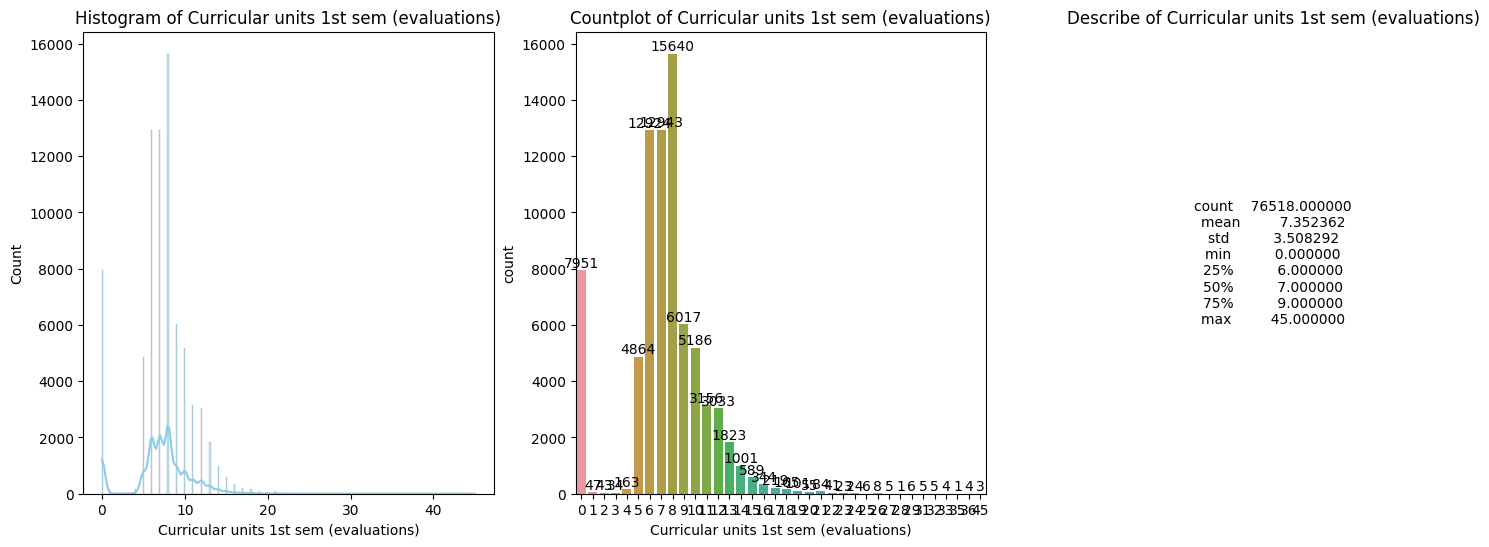

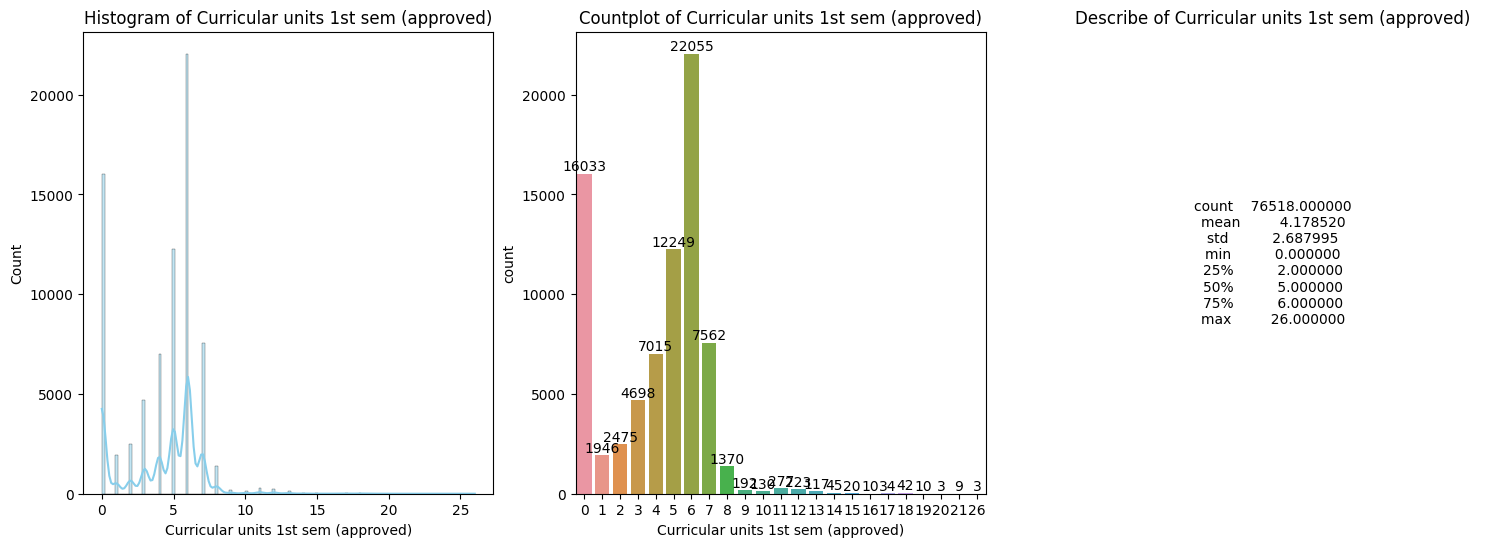

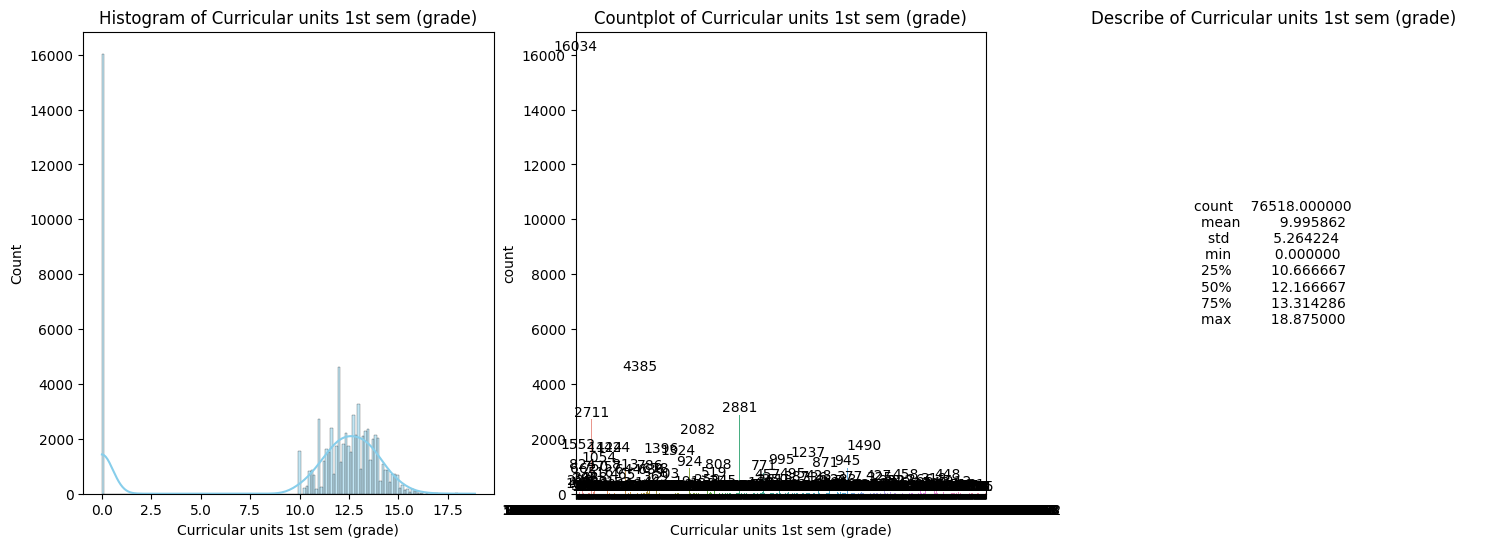

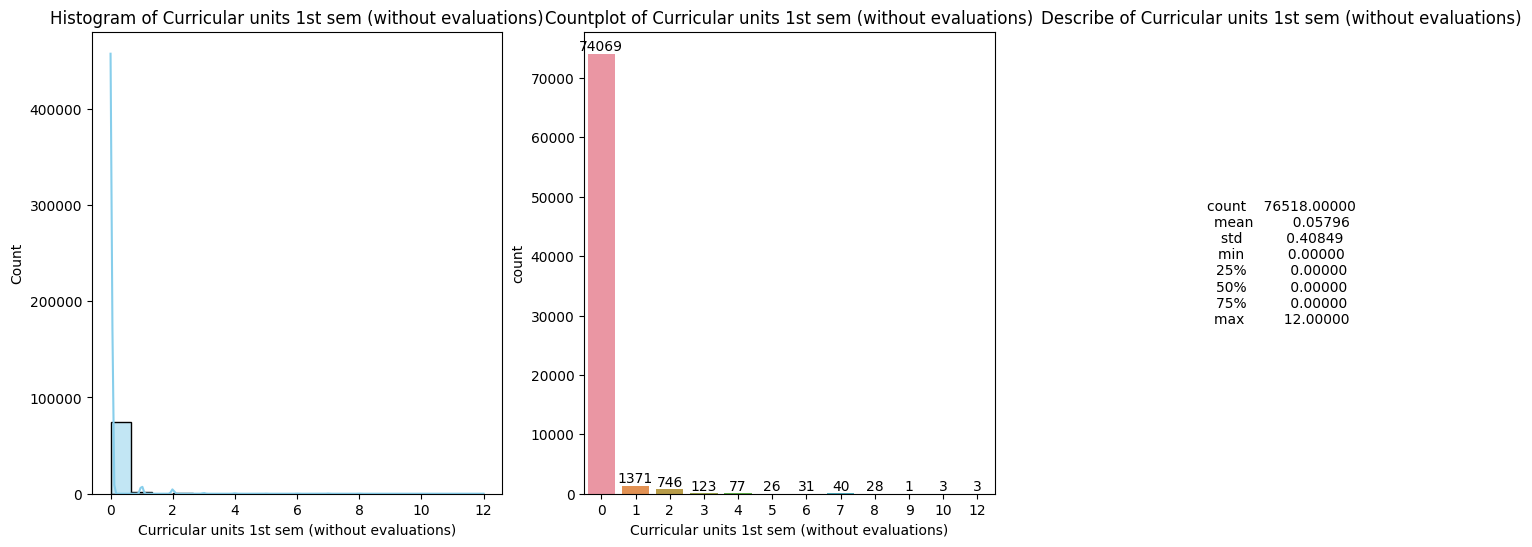

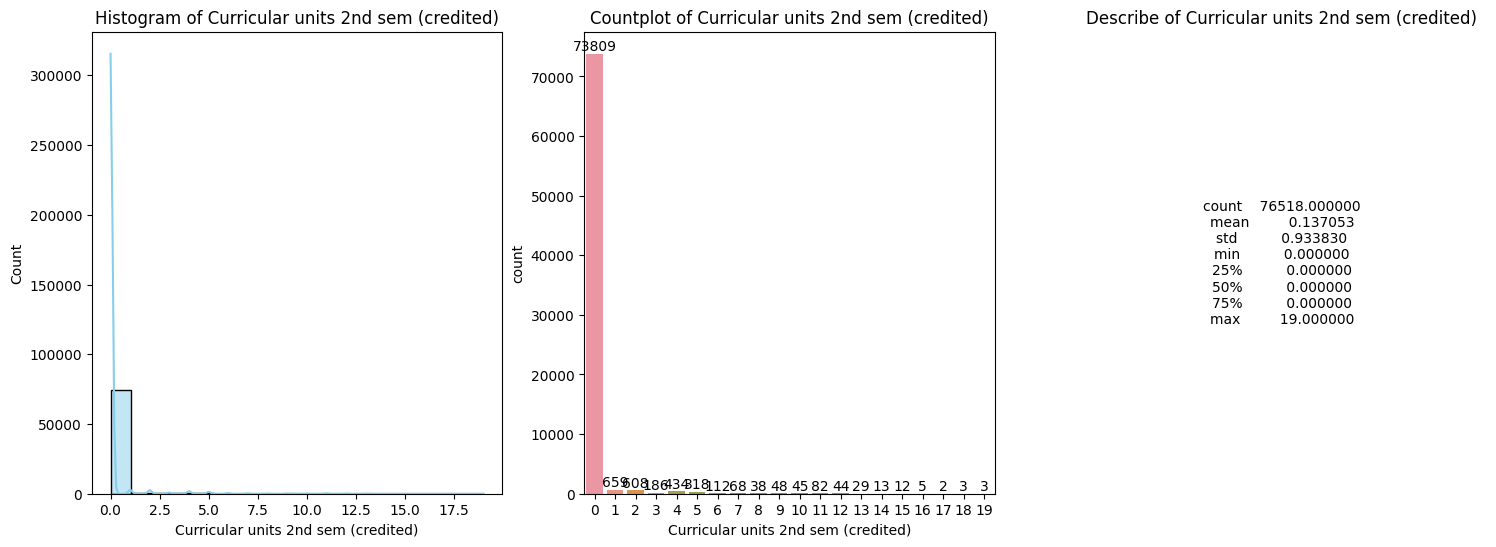

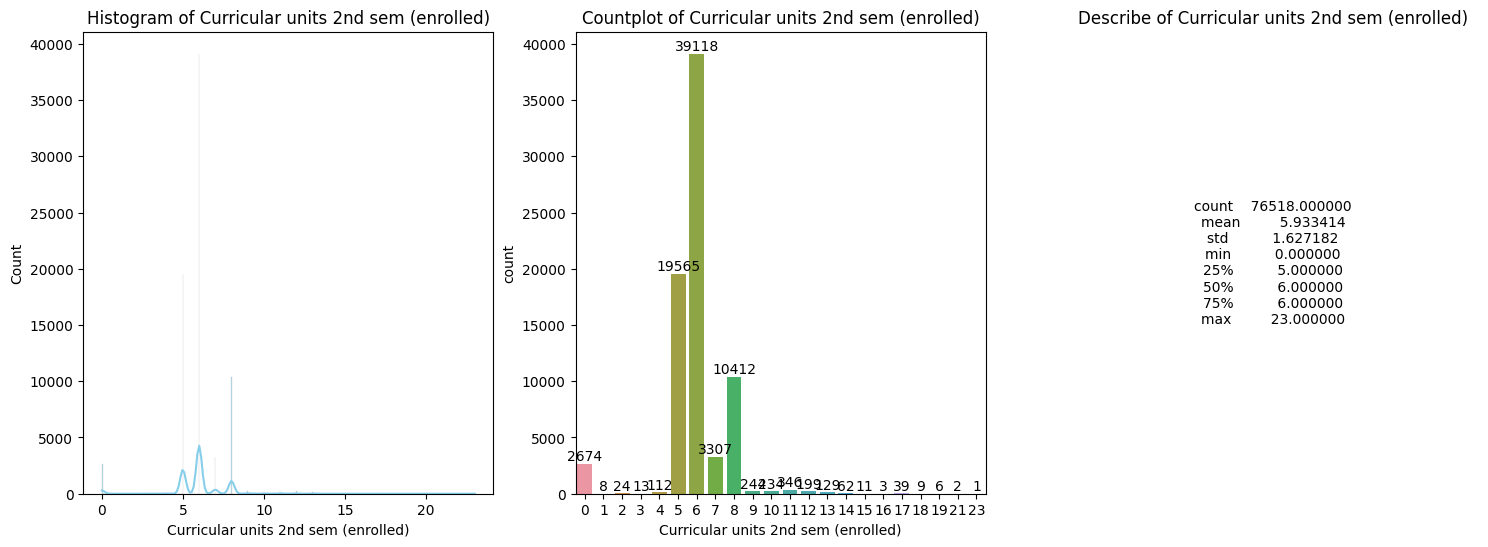

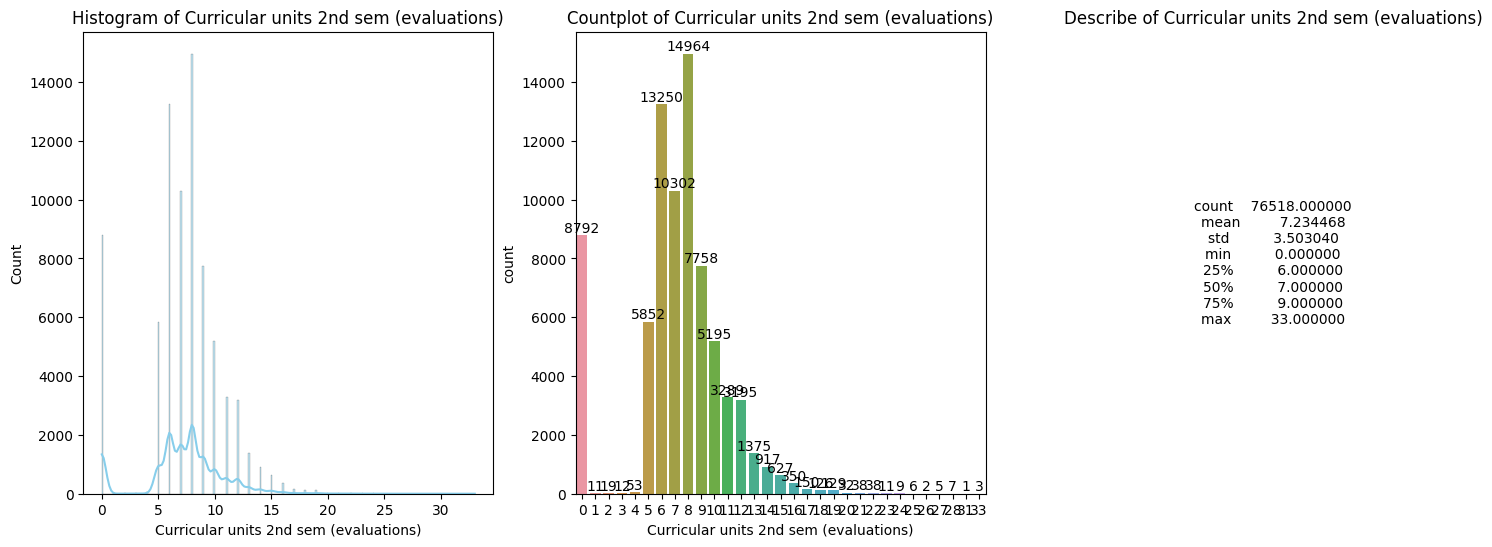

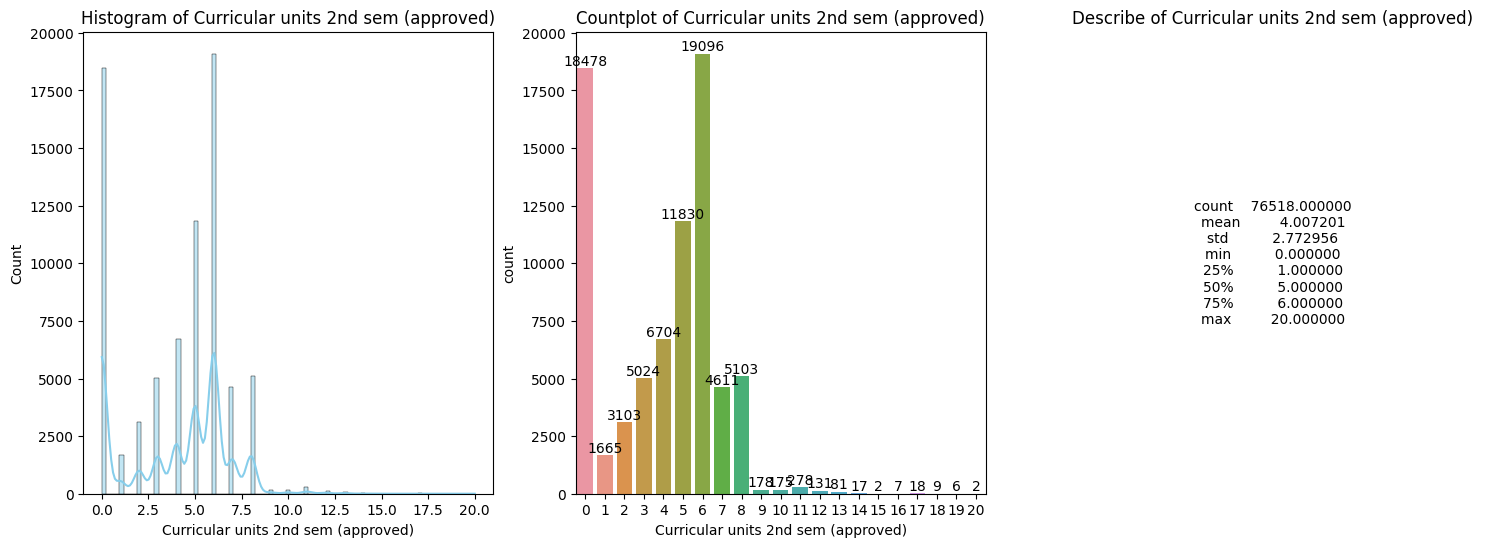

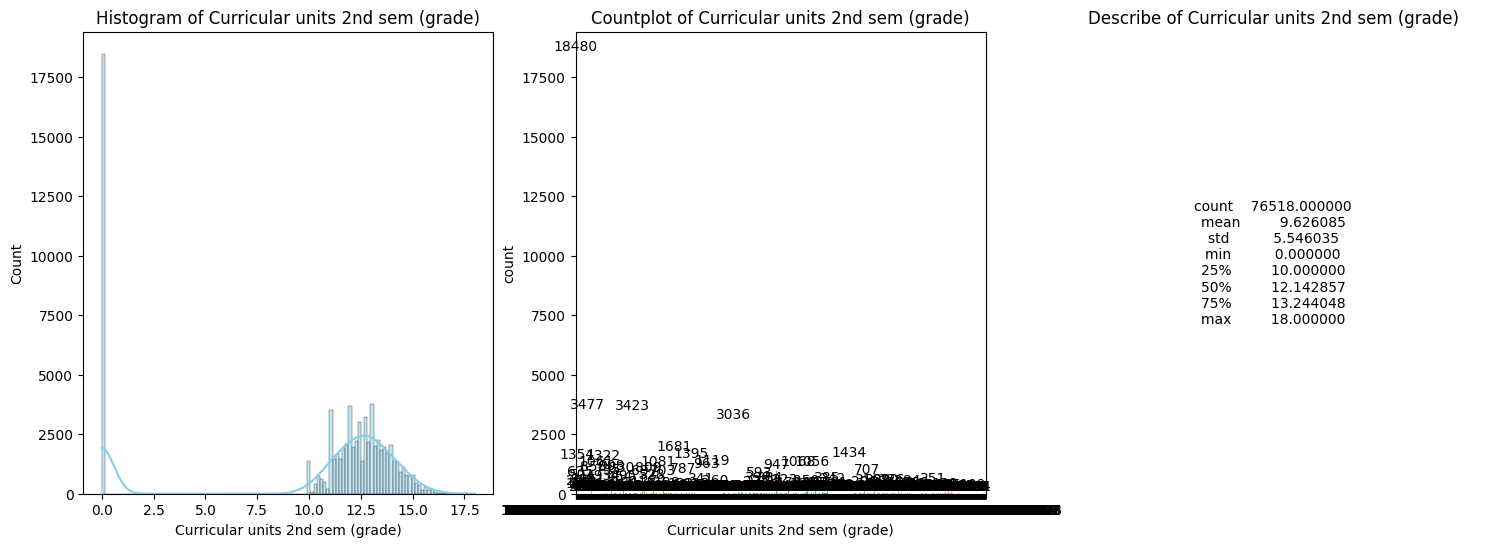

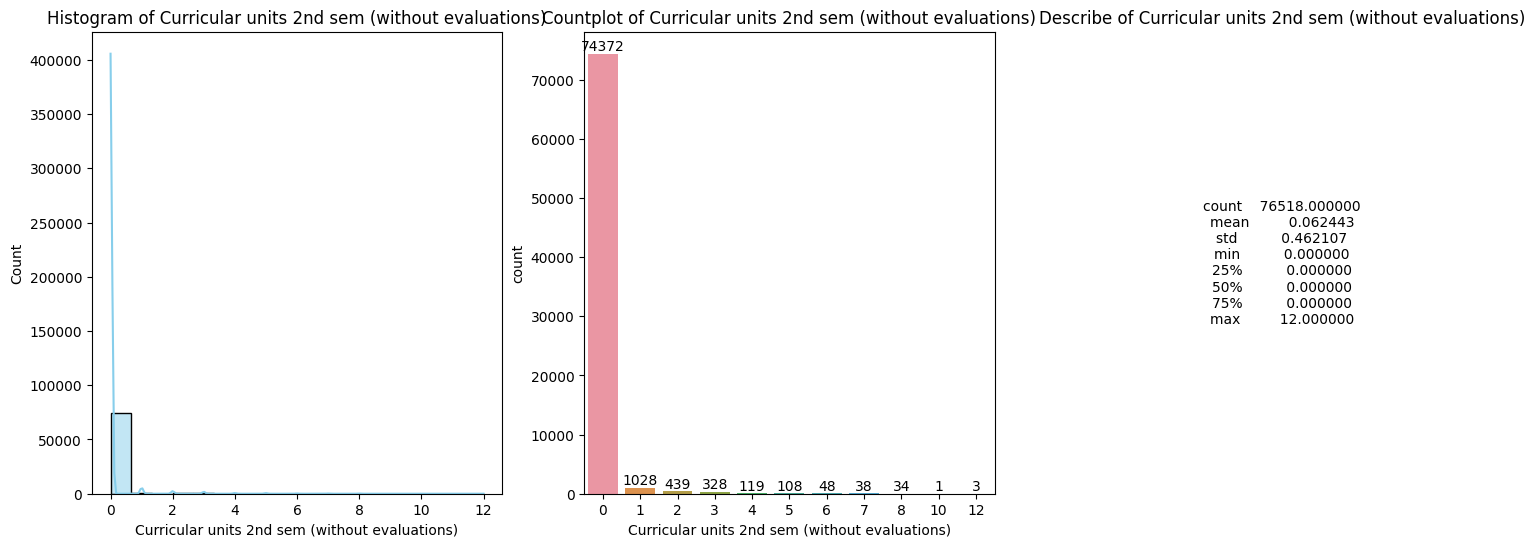

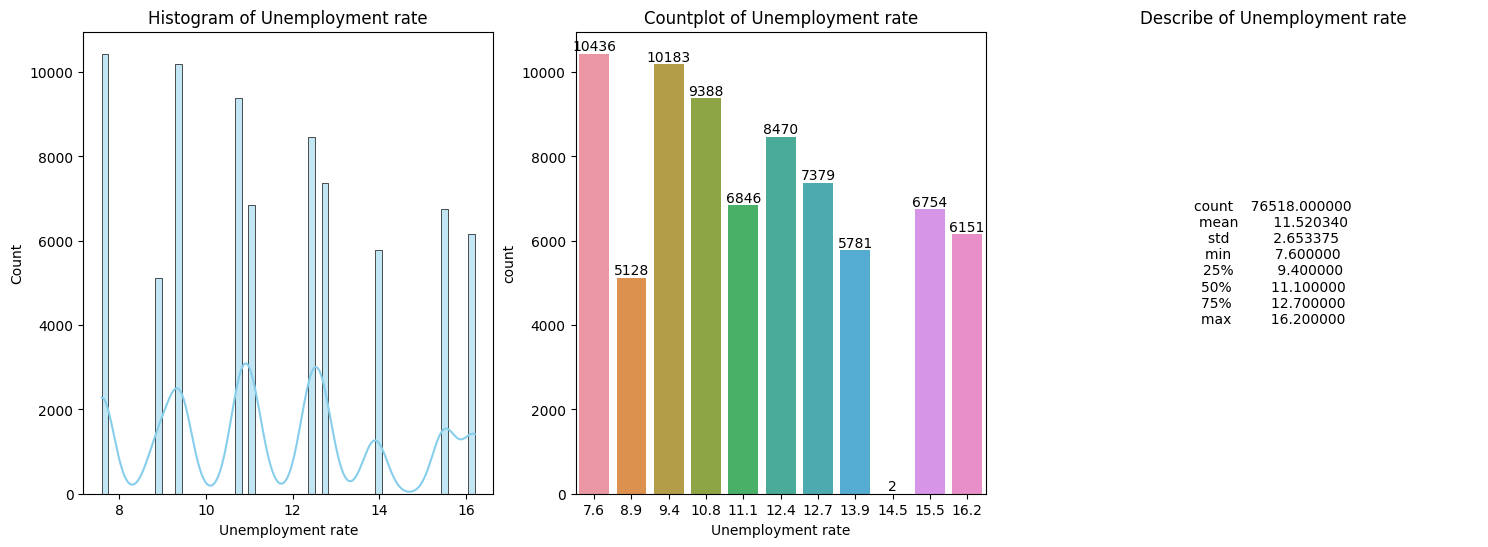

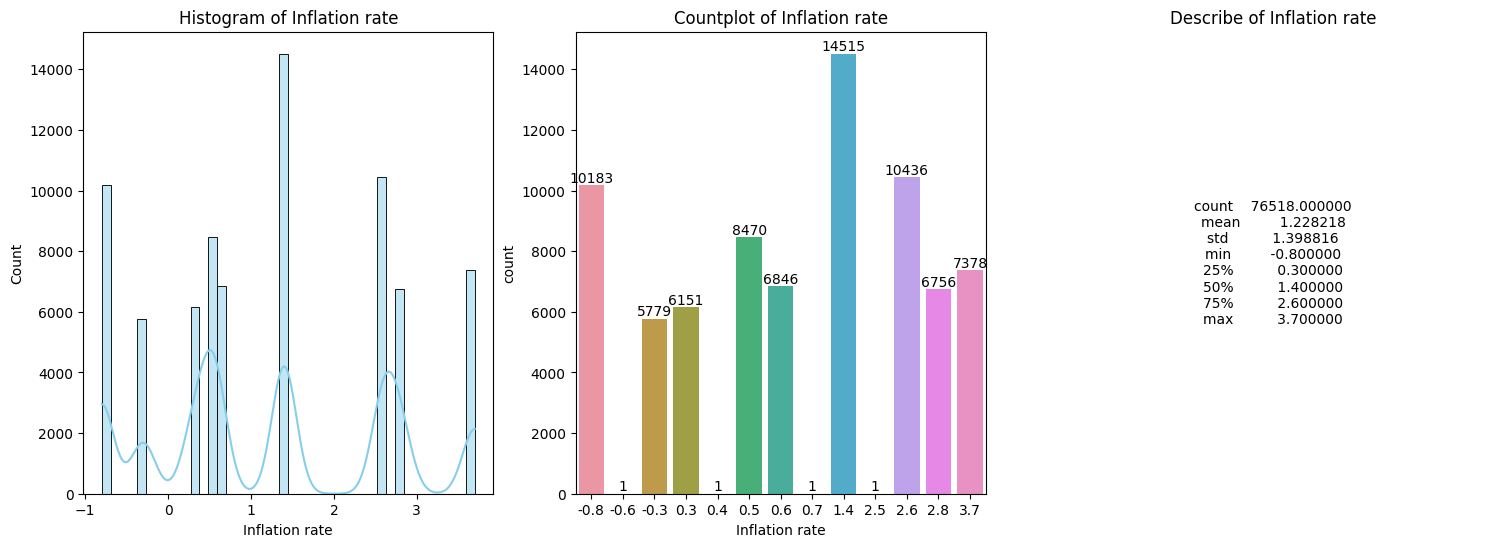

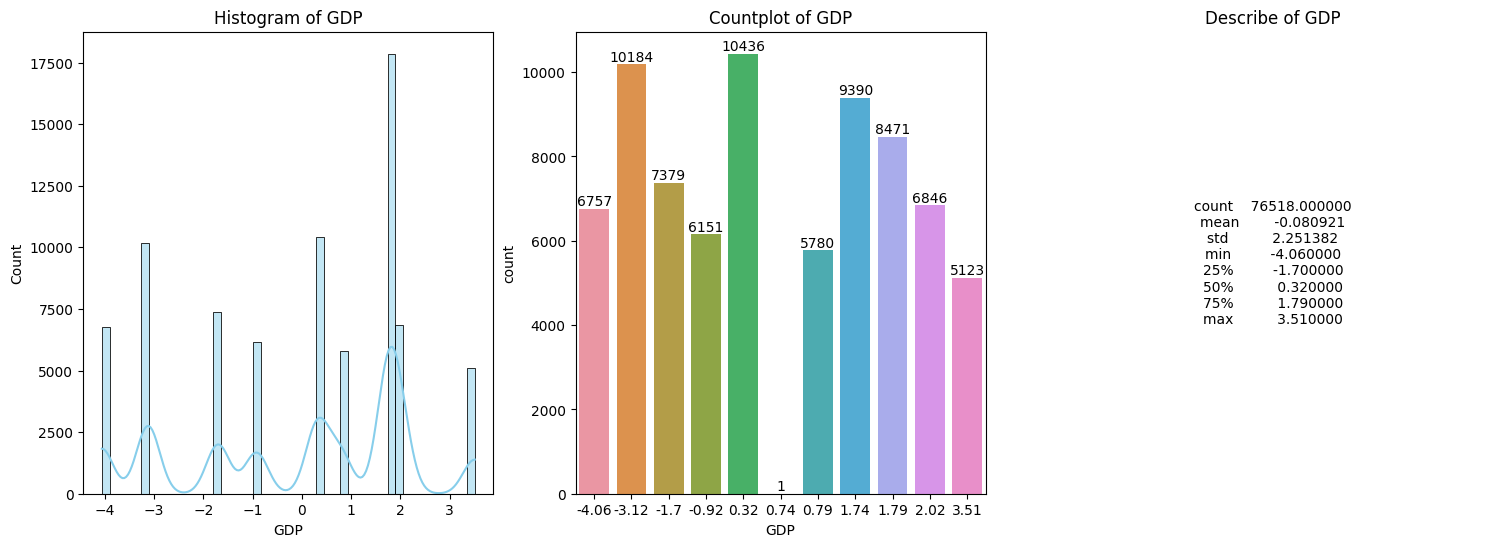

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns = df.drop('Target', axis=1).columns

# Loop through each column and create a histogram, countplot, and describe plot
for i in columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Histogram plot
    sns.histplot(df[i], ax=axes[0], kde=True, color='skyblue')
    axes[0].set_title(f"Histogram of {i}")

    # Countplot
    sns.countplot(data=df, x=i, ax=axes[1])
    axes[1].set_title(f"Countplot of {i}")
    axes[1].bar_label(axes[1].containers[0])

    # Describe function
    axes[2].text(0.5, 0.5, df[i].describe().to_string(), ha='center', va='center', fontsize=10)
    axes[2].axis('off')
    axes[2].set_title(f"Describe of {i}")

    plt.show()


In [5]:
def col_trans(df):

  df['Marital status'] = df['Marital status'].apply(lambda x: 3 if x > 2 else x)
#df_test['Marital status'] = df_test['Marital status'].apply(lambda x: 3 if x > 2 else x)

  df['Application order'] = df['Application order'].apply(lambda x: 1 if x ==1 else 0)
#df_test['Application order'] = df_test['Application order'].apply(lambda x: 1 if x ==1 else 0)

  df['Previous qualification']=df['Previous qualification'].apply(lambda x: 0 if x > 1 else x)
#df_test['Previous qualification']=df_test['Previous qualification'].apply(lambda x: 0 if x > 1 else x)

  df['International'] = df['International'].apply(lambda x: 0 if x > 1 else x)
#df_test['International'] = df_test['International'].apply(lambda x: 0 if x > 1 else x)

  df["Mother's qualification"] = df["Mother's qualification"].apply(lambda x: x if x in [1,19,37,38]  else 0)
#df_test['Mother\'s qualification'] = df_test['Mother\'s qualification'].apply(lambda x: x if x in [1,19,37,38]  else 'others')

  df['Father\'s qualification'] = df['Father\'s qualification'].apply(lambda x: x if x in [1,19,37,38]  else 0)
#df_test['Father\'s qualification'] = df_test['Father\'s qualification'].apply(lambda x: x if x in [1,19,37,38]  else 'others')

  df['Father\'s occupation'] = df['Father\'s occupation'].apply(lambda x: 11 if x > 10 else x)
#df_test['Father\'s occupation'] = df_test['Father\'s occupation'].apply(lambda x: 12 if x > 11 else x)

  df['Mother\'s occupation'] = df['Mother\'s occupation'].apply(lambda x: 11 if x > 10 else x)
#df_test['Mother\'s occupation'] = df_test['Mother\'s occupation'].apply(lambda x: 11 if x > 10 else x)

  df['Age at enrollment'] = df['Age at enrollment'].apply(lambda x: 1 if x <20 else 2 if 19<x<23 else 3)
#df_test['Age at enrollment'] = df_test['Age at enrollment'].apply(lambda x: 1 if x <20 else 2 if 19<x<23 else 3)

  df['Curricular units 1st sem (without evaluations)'] = df['Curricular units 1st sem (without evaluations)'].apply(lambda x:1 if x > 0 else x)
#df_test['Curricular units 1st sem (without evaluations)'] = df_test['Curricular units 1st sem (without evaluations)'].apply(lambda x:1 if x > 0 else x)

  df['Curricular units 1st sem (credited)'] = df['Curricular units 1st sem (credited)'].apply(lambda x:1 if x > 0 else x)
#df_test['Curricular units 1st sem (credited)'] = df_test['Curricular units 1st sem (credited)'].apply(lambda x:1 if x > 0 else x)

  df['Curricular units 2nd sem (credited)'] = df['Curricular units 2nd sem (credited)'].apply(lambda x:1 if x > 0 else x)
#df_test['Curricular units 2nd sem (credited)'] = df_test['Curricular units 2nd sem (credited)'].apply(lambda x:1 if x > 0 else x)

  df['Curricular units 2nd sem (approved)'] = df['Curricular units 2nd sem (approved)'].apply(lambda x:9 if x > 8 else x)
#df_test['Curricular units 2nd sem (approved)'] = df_test['Curricular units 2nd sem (approved)'].apply(lambda x:9 if x > 8 else x)

  df['Curricular units 2nd sem (without evaluations)'] = df['Curricular units 2nd sem (without evaluations)'].apply(lambda x:1 if x > 0 else x)
#df_test['Curricular units 2nd sem (without evaluations)'] = df_test['Curricular units 2nd sem (without evaluations)'].apply(lambda x:1 if x > 0 else x)
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  df['Curricular units 1st sem (enrolled)']=df['Curricular units 1st sem (enrolled)'].apply(lambda x:x if x in [5,6,7,8] else 0)
#df_test['Curricular units 1st sem (enrolled)']=df_test['Curricular units 1st sem (enrolled)'].apply(lambda x:x if x in [5,6,7,8] else 0)

  df['Curricular units 2nd sem (enrolled)']=df['Curricular units 2nd sem (enrolled)'].apply(lambda x:x if x in [5,6,7,8] else 0)
#df_test['Curricular units 2nd sem (enrolled)']=df_test['Curricular units 2nd sem (enrolled)'].apply(lambda x:x if x in [5,6,7,8] else 0)

  df['Curricular units 1st sem (approved)'] = df['Curricular units 1st sem (approved)'].apply(lambda x:x if x < 9 else 10)
#df_test['Curricular units 1st sem (approved)'] = df_test['Curricular units 1st sem (approved)'].apply(lambda x:x if x < 9 else 10)
  return df

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [6]:
custom_column = ['Marital status','Application order','Previous qualification',
        'Daytime/evening attendance',"Mother's qualification","Father's qualification",
        'International','Father\'s occupation','Mother\'s occupation','Age at enrollment','Curricular units 1st sem (without evaluations)',
        'Curricular units 1st sem (credited)','Curricular units 2nd sem (credited)','Curricular units 2nd sem (approved)',
        'Curricular units 2nd sem (without evaluations)','Curricular units 1st sem (enrolled)','Curricular units 2nd sem (enrolled)',
        'Curricular units 1st sem (approved)']

# keeping all features except nacionality
#Make it categorical
cat=df[['Unemployment rate','Curricular units 1st sem (enrolled)','Curricular units 1st sem (approved)','Curricular units 2nd sem (enrolled)',
       'Inflation rate', 'GDP','Curricular units 2nd sem (without evaluations)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (credited)',
        'Curricular units 1st sem (without evaluations)','Curricular units 1st sem (credited)','Marital status','Application order','Previous qualification',
        'Daytime/evening attendance',"Mother's qualification","Father's qualification",
        'International','Father\'s occupation','Mother\'s occupation','Age at enrollment']]

cat_test=df_test[['Unemployment rate','Curricular units 1st sem (enrolled)','Curricular units 1st sem (approved)','Curricular units 2nd sem (enrolled)',
       'Inflation rate', 'GDP','Curricular units 2nd sem (without evaluations)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (credited)',
        'Curricular units 1st sem (without evaluations)','Curricular units 1st sem (credited)','Marital status','Application order','Previous qualification',
        'Daytime/evening attendance',"Mother's qualification","Father's qualification",
        'International','Father\'s occupation','Mother\'s occupation','Age at enrollment']]


#Make it numerical
num=df[['Application mode','Curricular units 1st sem (evaluations)','Previous qualification (grade)','Admission grade','Curricular units 1st sem (grade)',
        'Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (grade)','Course']]

num_test=df_test[['Application mode','Curricular units 1st sem (evaluations)','Previous qualification (grade)','Admission grade','Curricular units 1st sem (grade)',
        'Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (grade)','Course']]

In [7]:
X= pd.concat([cat,num],axis=1)
Y=df['Target'].replace({'Graduate':0,'Dropout':1,'Enrolled':2})

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [9]:
preprocess=ColumnTransformer([
    ('custom_transform',FunctionTransformer(func=col_trans,validate=False),custom_column),
    ('num',StandardScaler(),num.columns),
    ('cat',OneHotEncoder(handle_unknown='ignore',drop='first',sparse=False),cat.columns)
])

In [10]:
lgbm = LGBMClassifier()
model=make_pipeline(preprocess,lgbm)
lgbm_mod=model.fit(x_train,Y_train)
y_pred=lgbm_mod.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 275
[LightGBM] [Info] Start training from score -0.746218
[LightGBM] [Info] Start training from score -1.106863
[LightGBM] [Info] Start training from score -1.633477


In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)

0.8170412963930999

In [12]:
import lightgbm

In [13]:
lgbm = LGBMClassifier(verbose=-1,random_state=42)
train_data = lightgbm.Dataset(x_train, label=Y_train)
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "learning_rate" : 0.05,
     "num_class": len(np.unique(Y_train))
}
model_ = lightgbm.train( params=params,train_set=train_data, num_boost_round=10)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 29
[LightGBM] [Info] Start training from score -0.746218
[LightGBM] [Info] Start training from score -1.106863
[LightGBM] [Info] Start training from score -1.633477


<Axes: title={'center': 'LightGBM Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

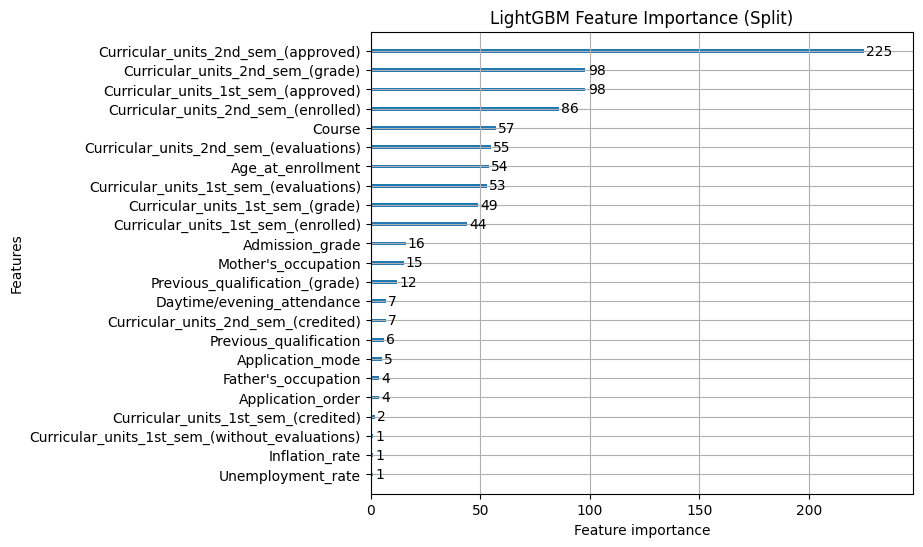

In [14]:
lightgbm.plot_importance(model_, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")

<BarContainer object of 29 artists>

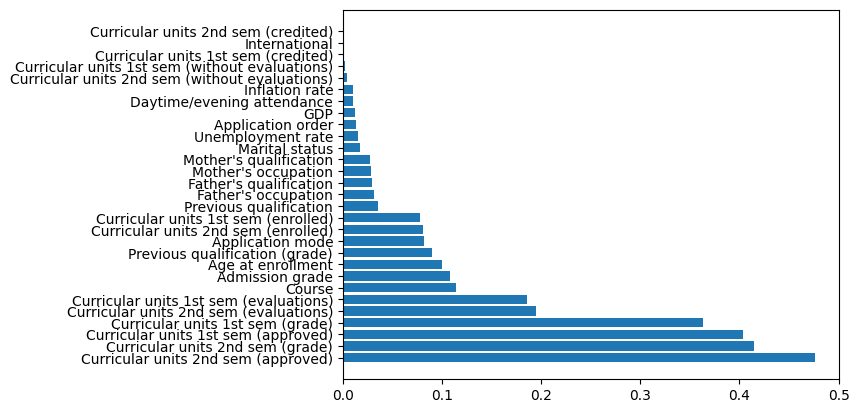

In [15]:
mut_info = pd.DataFrame({'feature':x_train.columns, 'mutual information':mutual_info_classif(x_train, Y_train,)})
mut_info = mut_info.sort_values(by = 'mutual information', ascending = False)
plt.barh(mut_info['feature'], mut_info['mutual information'])

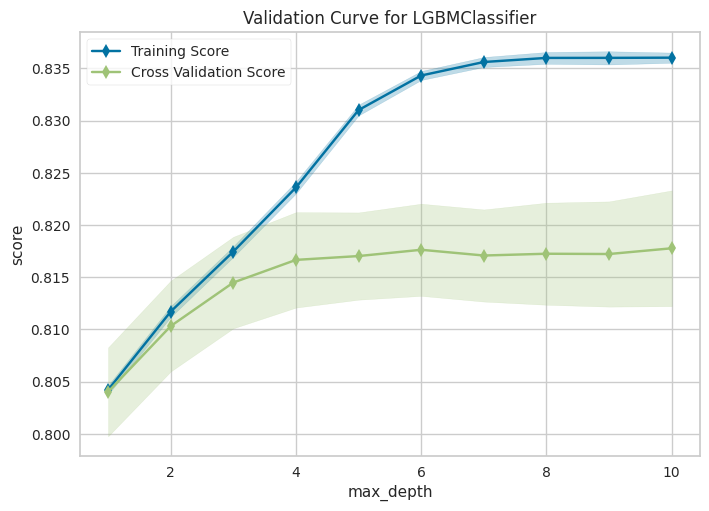

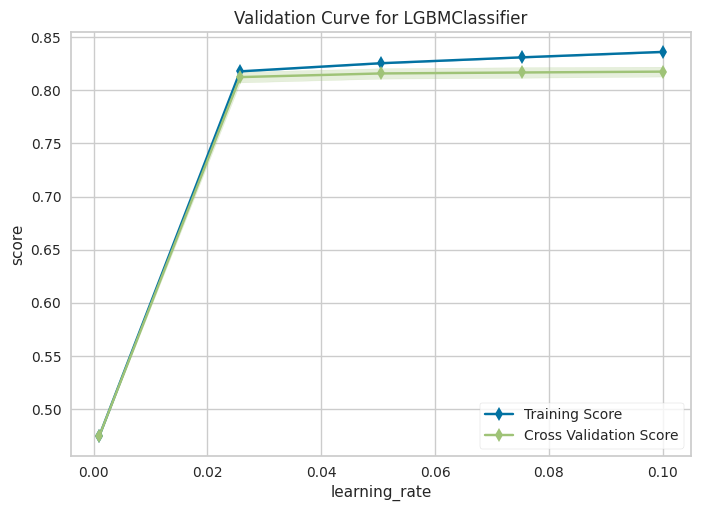

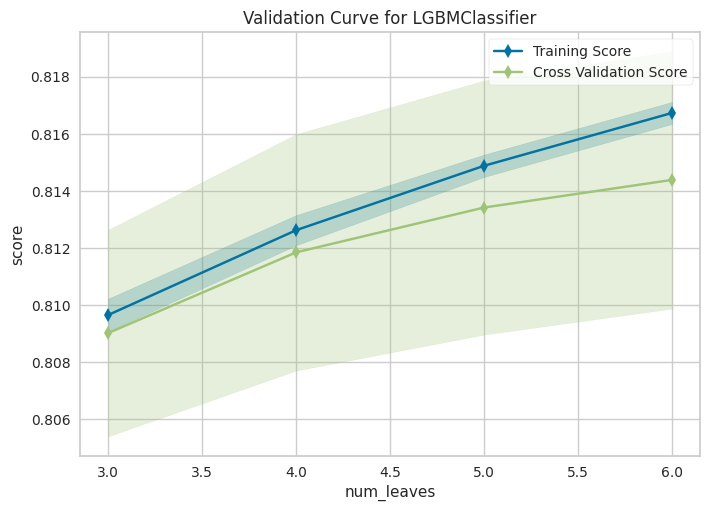

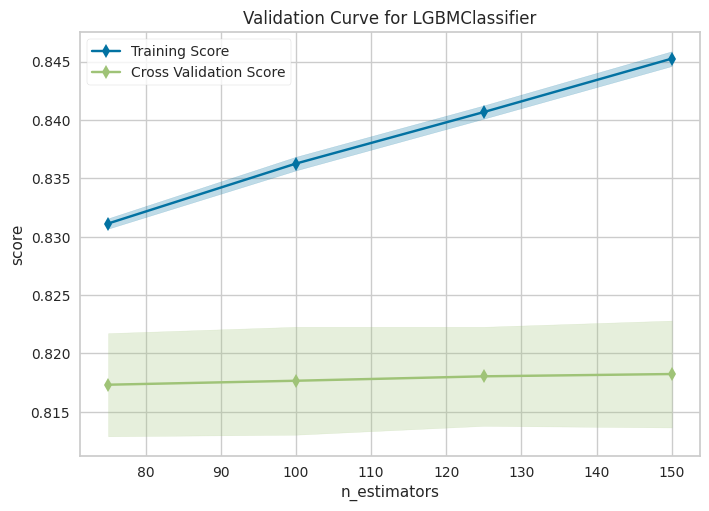

<Axes: title={'center': 'Validation Curve for LGBMClassifier'}, xlabel='n_estimators', ylabel='score'>

In [16]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    LGBMClassifier(verbose=-1), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="accuracy"
)
# Fit and show the visualizer
viz.fit(X, Y)
viz.show()


viz = ValidationCurve(
    LGBMClassifier(verbose=-1), param_name="learning_rate",
    param_range=np.linspace(0.001,0.1,5), cv=10, scoring="accuracy"
)
# Fit and show the visualizer
viz.fit(X, Y)
viz.show()

viz = ValidationCurve(
    LGBMClassifier(verbose=-1), param_name="num_leaves",
    param_range=np.arange(3,7), cv=10, scoring="accuracy"
)
# Fit and show the visualizer
viz.fit(X, Y)
viz.show()

viz = ValidationCurve(
    LGBMClassifier(verbose=-1), param_name="n_estimators",
    param_range=[75,100,125,150], cv=10, scoring="accuracy"
)
# Fit and show the visualizer
viz.fit(X, Y)
viz.show()



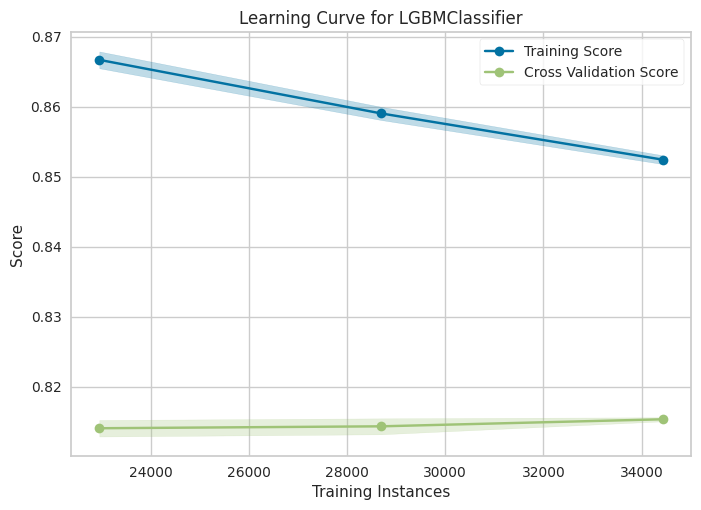

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [17]:
from yellowbrick.model_selection import LearningCurve
import matplotlib.pyplot as plt
lgbm = LGBMClassifier(verbose=-1,random_state=42)

model1=make_pipeline(preprocess,lgbm)
sizes = np.linspace(0.6, 0.9, 3)
visualizer2=LearningCurve(model1,cv=2,scoring='accuracy',train_sizes=sizes)
visualizer2.fit(X,Y)
visualizer2.show()


In [18]:
lgbm = LGBMClassifier(verbose=-1,random_state=42)
model=make_pipeline(preprocess,lgbm)

lgbm_mod=model.fit(X,Y)
y_pred=lgbm_mod.predict(df_test)

In [19]:
sub=df_test[["id"]]
sub['Target']=y_pred
sub.replace({0:'Graduate',1:'Dropout',2:'Enrolled'},inplace=True)
sub.to_csv('submission.csv',index=False)